## *Importing the libraries*

In [ ]:
from array import *
import copy
import random
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.7.0'

## *Loading the MNIST dataset*

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

## *Data Visualization*

Text(0.5, 1.0, '3')

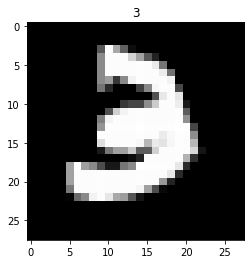

In [ ]:
# visualize one random hand written digit
i = np.random.randint(0, 60000)
plt.imshow(X_train[i], cmap='gray');
plt.title(y_train[i])

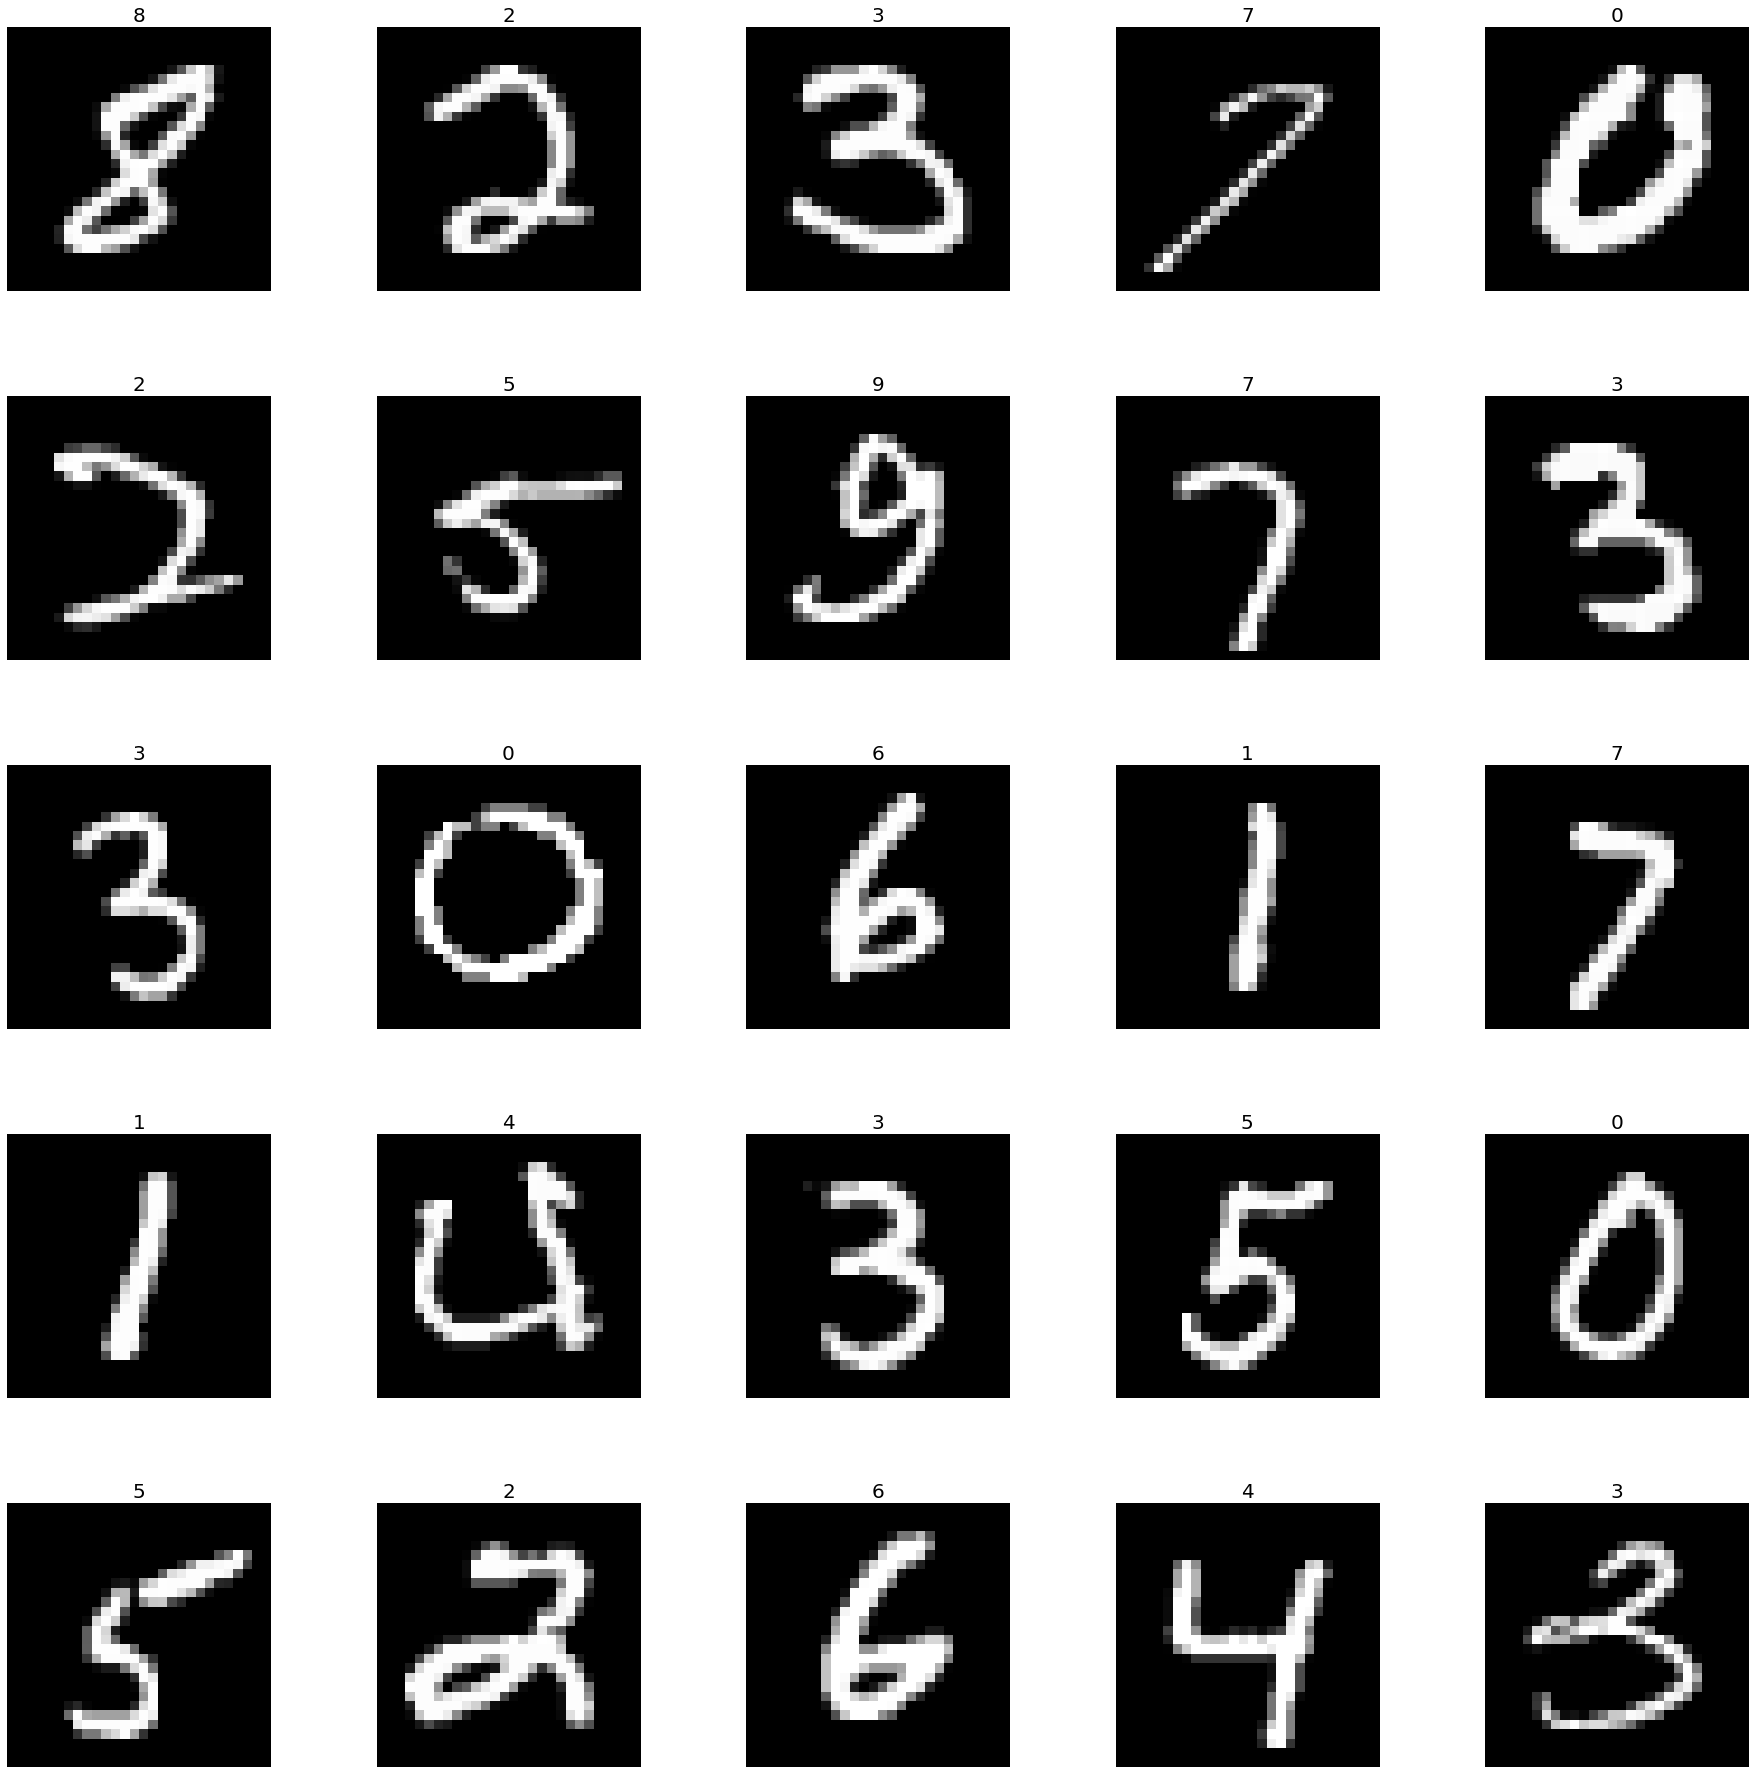

In [ ]:
l_grid = 5
w_grid = 5
fig, axes = plt.subplots(l_grid, w_grid, figsize = (32, 32))
axes = axes.ravel()
for i in range(0, l_grid*w_grid):
  j = np.random.randint(0, len(X_train))
  axes[i].imshow(X_train[j], cmap = 'gray')
  axes[i].set_title(y_train[j], fontsize = 20)
  axes[i].axis('off')
plt.subplots_adjust(hspace = 0.4)

## *Data Pre-processing*

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
np.shape(X_train)

(60000, 28, 28, 1)

In [ ]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

In [ ]:
# standardization between -1 to 1
X_train = (X_train / 127.5) - 1.0

In [ ]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [ ]:
buffer_size = 60000
batch_size = 32
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [ ]:
X_train

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

## *Model Building*

In [ ]:
# building the generator
def build_generator():
  model = tf.keras.Sequential()

  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('swish'))
  model.add(layers.Reshape((7, 7, 256)))

  # 7x7x128
  model.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('swish'))

  # 14x14x64
  model.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('swish'))

  # 28x28x1
  model.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding='same', use_bias=False, activation='tanh'))

  model.summary()

  return model

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
print(noise)

tf.Tensor(
[[-0.16228457  0.75067955 -1.0666898  -0.24219821 -1.0095176   0.42684337
   0.30286747  0.2501689   1.5830059   0.4250913  -0.64811146 -1.9269332
   1.3024273  -0.09184241  0.18027657  0.6817446   0.29177952  0.8410222
  -1.4190457   1.2501813  -0.9132902   0.52531236  1.5519414   0.7672756
  -0.07426365 -1.999541   -0.64853096  1.2075667  -0.9575196   0.40203562
   0.3308881  -0.22428535 -1.8283963   0.01867738 -0.5458182   0.00282184
  -0.02828076  0.09580224 -0.38687813 -0.11914593 -0.7067526  -0.05228718
  -1.2693202  -0.16648264 -1.7647722  -1.1511264  -0.10521651 -0.54415435
  -0.74899656 -0.09318592  0.33452955 -0.09600776 -0.8011941  -0.37789953
  -0.48877457  0.98333424  0.3112629  -0.04094401  1.8207626   0.5674601
  -1.4022802  -0.6930458  -0.23697732  1.2674328   0.02506364  0.26109582
  -0.5532843   1.2371824  -1.9420047   1.5019959  -0.00402701 -0.83407784
  -1.8734188   1.8635944   0.42626205  0.14970131  0.4975853   0.32133558
  -0.463688    0.9875583  -0.08

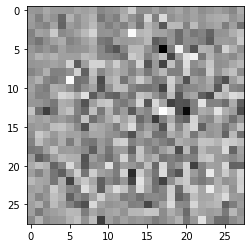

In [ ]:
# visualize one noise
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0,:,:,0], cmap='gray');

In [ ]:
# building the discriminator
def build_discriminator():
  model = tf.keras.Sequential()

  # 14x14x32
  model.add(layers.Conv2D(32, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.Activation('swish'))
  model.add(layers.Dropout(0.2))

  # 7x7x64
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same'))
  model.add(layers.Activation('swish'))
  model.add(layers.Dropout(0.2))

  # 4x4x128
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.Activation('swish'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation = 'tanh'))

  model.summary()

  return model

In [ ]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 activation_3 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 activation_4 (Activation)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)        

## *Loss Calculation*

In [ ]:
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy_loss(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy_loss(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy_loss(tf.ones_like(fake_output), fake_output)

## *Define Optimizers*

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

## *Model Training*

In [ ]:
epochs = 100
noise_dim = 100
num_images_to_generate = 16

In [ ]:
print(batch_size)
print(noise_dim)

32
100


In [ ]:
@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])

In [ ]:
test_images.shape

TensorShape([16, 100])

In [ ]:
def train(dataset, epochs, test_images):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_steps(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Epoch:  1


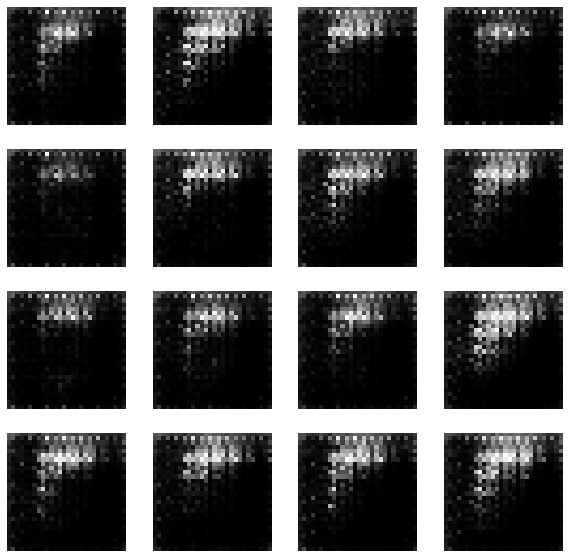

Epoch:  2


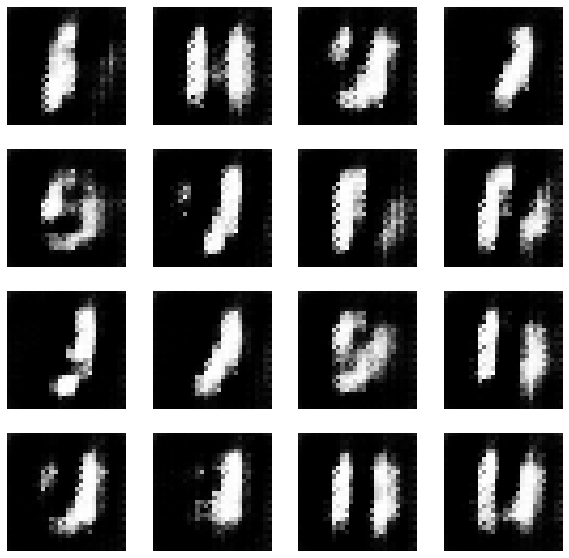

Epoch:  3


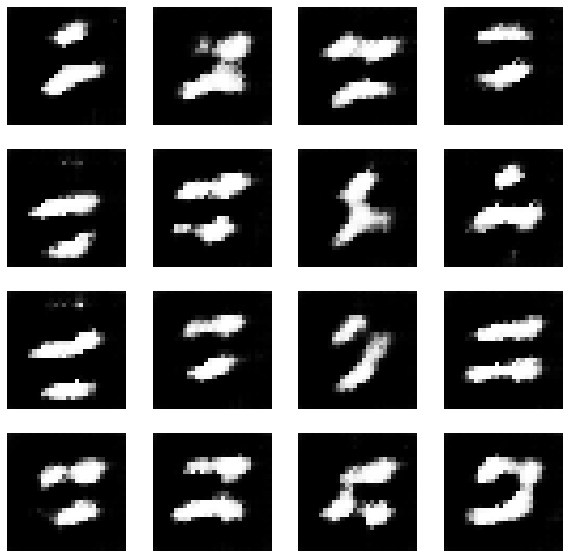

Epoch:  4


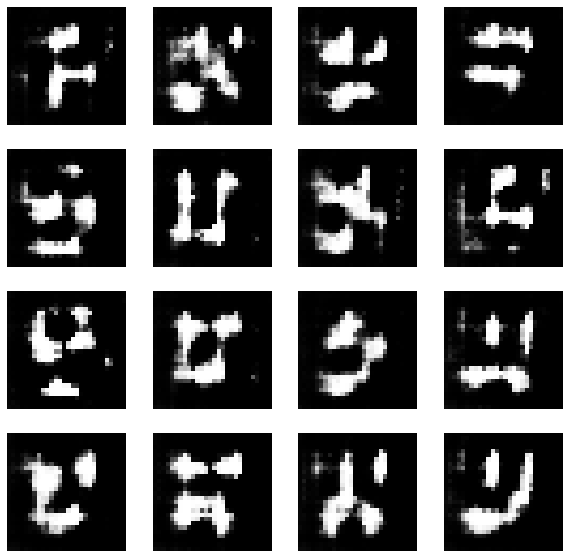

Epoch:  5


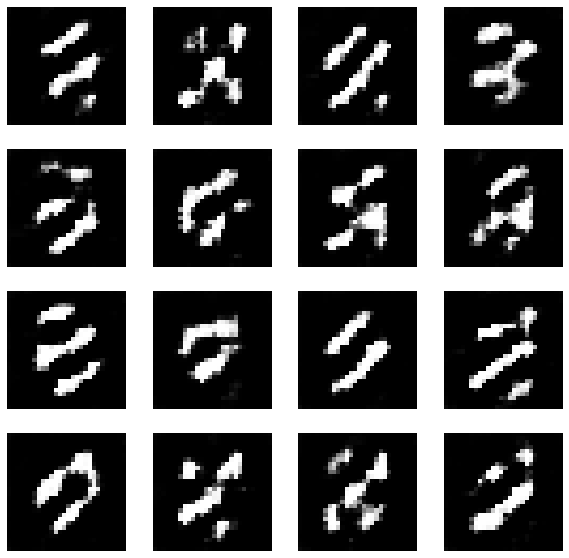

Epoch:  6


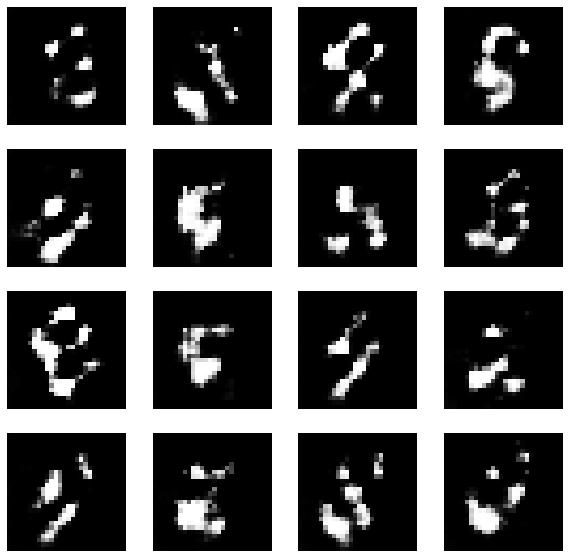

Epoch:  7


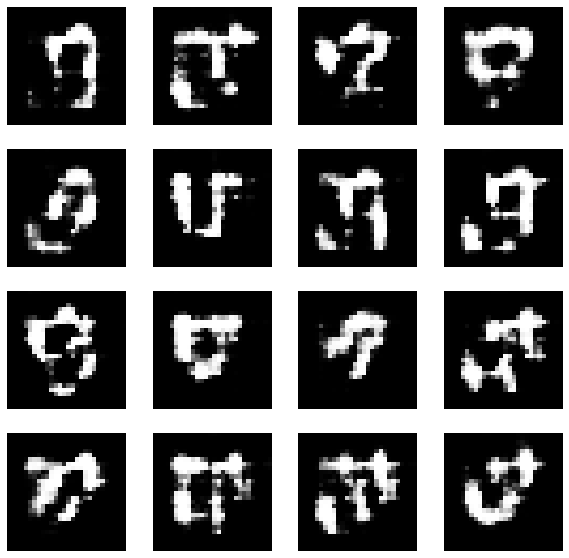

Epoch:  8


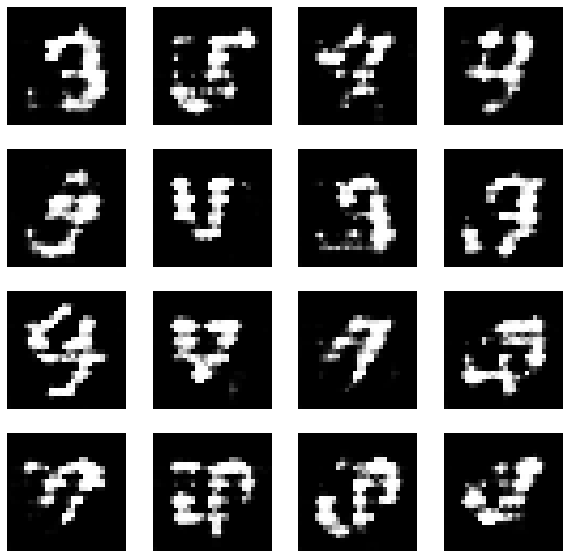

Epoch:  9


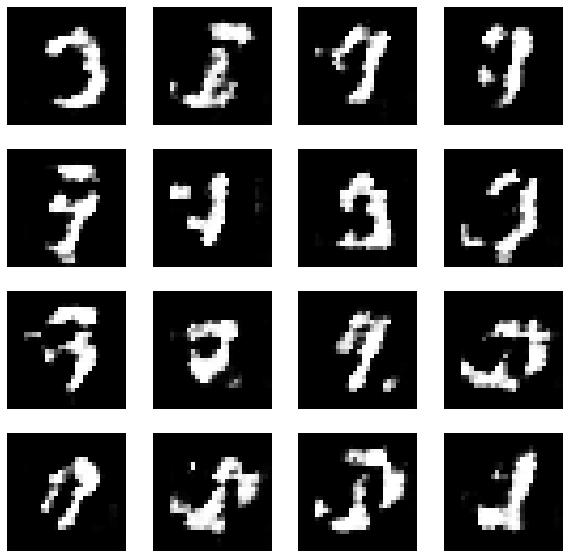

Epoch:  10


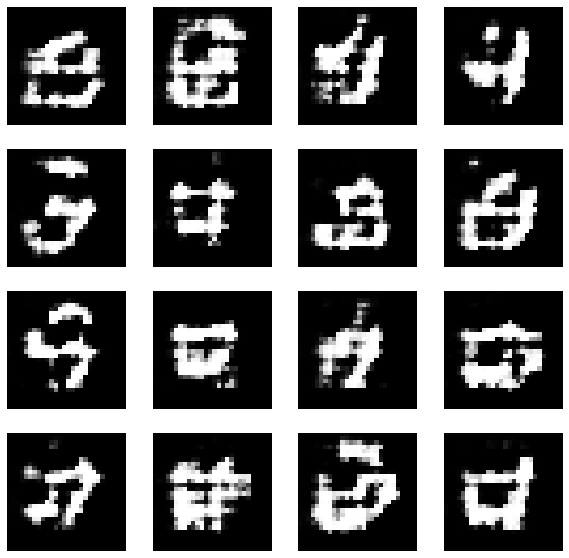

Epoch:  11


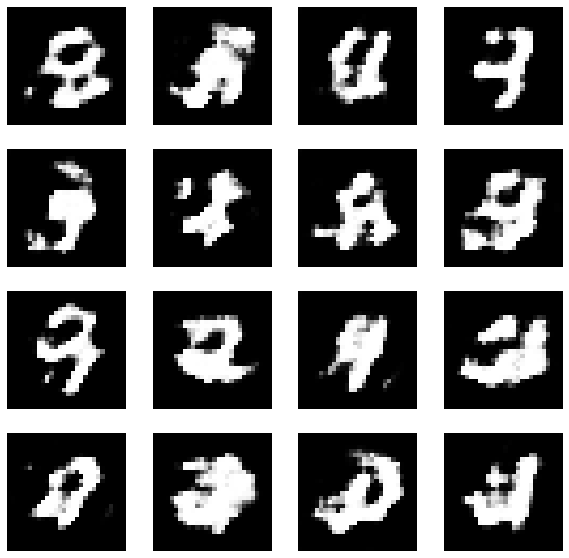

Epoch:  12


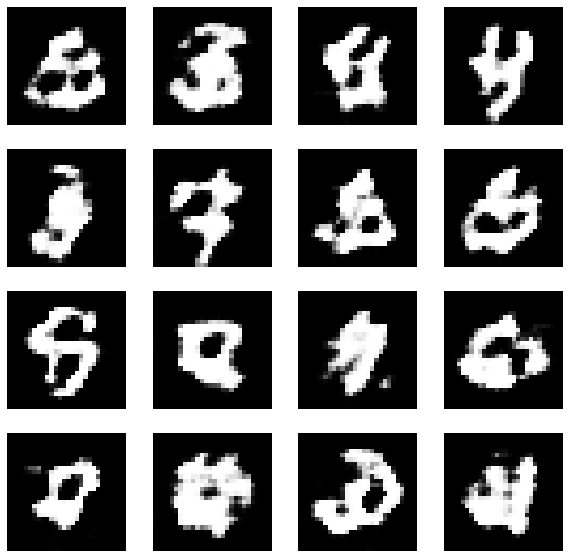

Epoch:  13


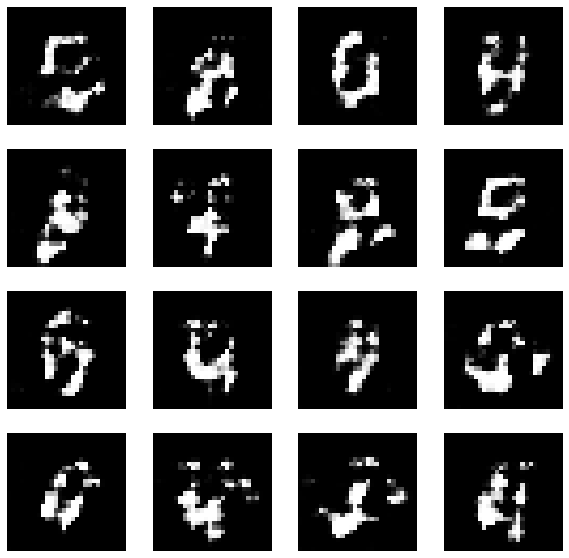

Epoch:  14


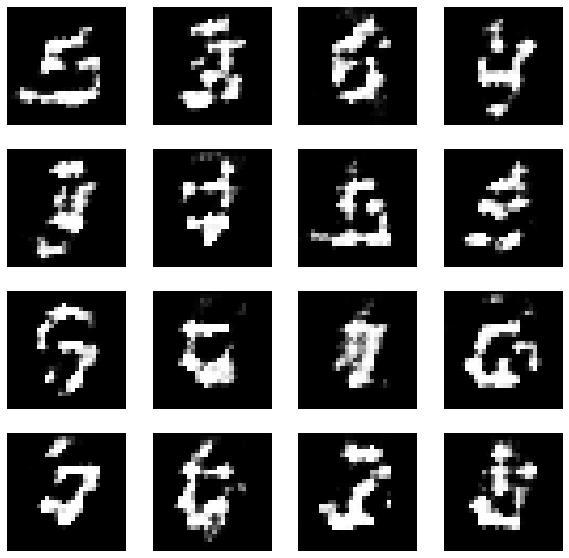

Epoch:  15


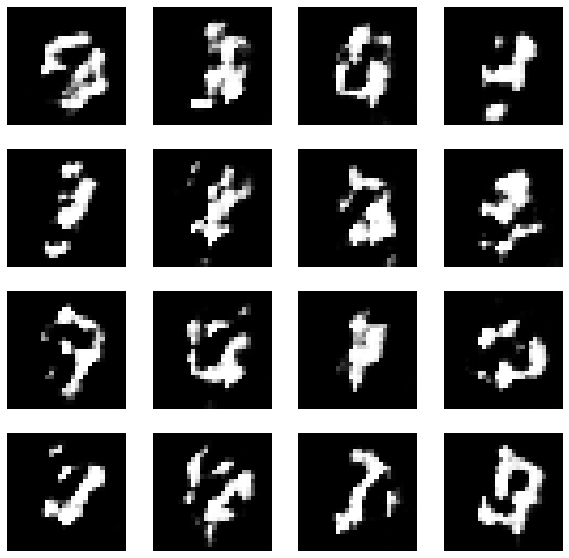

Epoch:  16


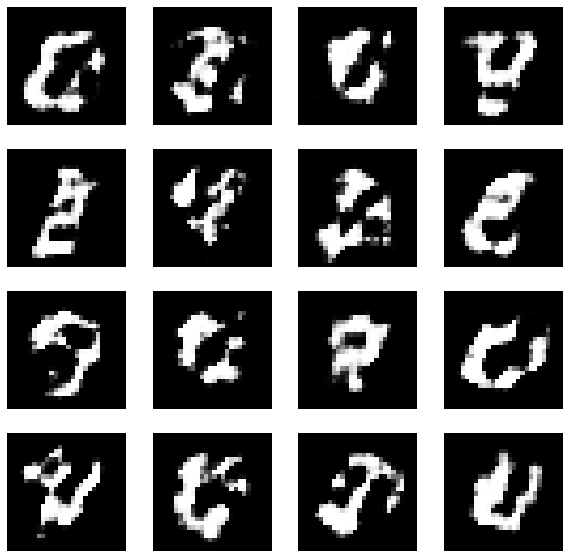

Epoch:  17


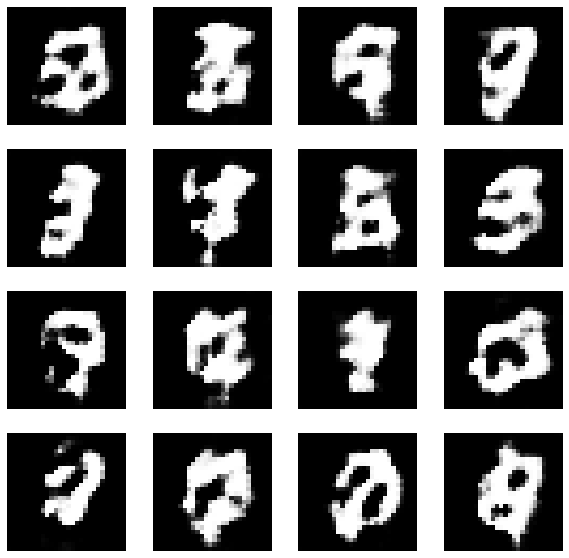

Epoch:  18


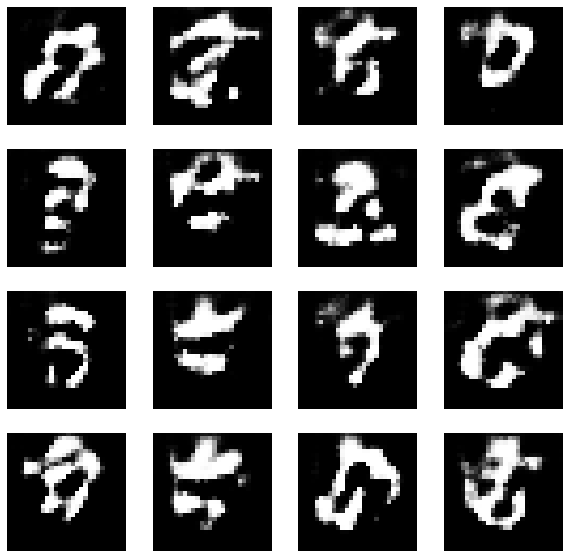

Epoch:  19


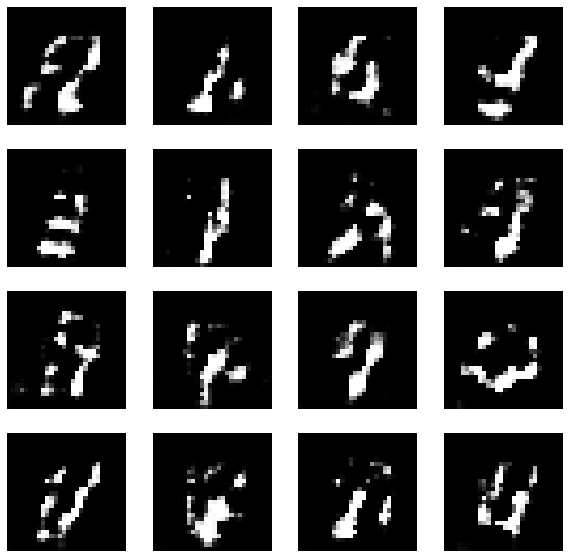

Epoch:  20


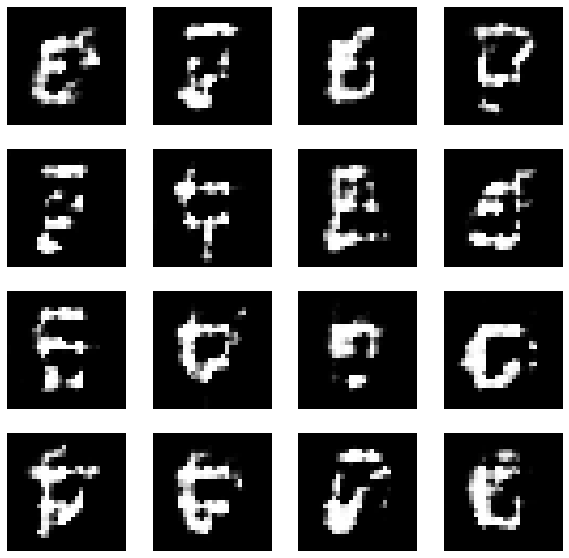

Epoch:  21


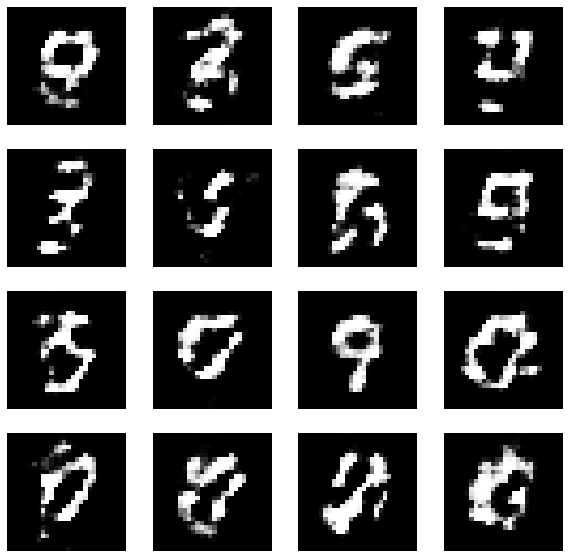

Epoch:  22


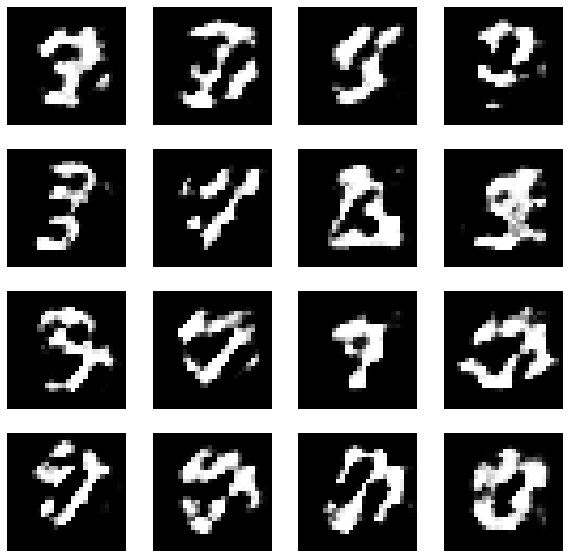

Epoch:  23


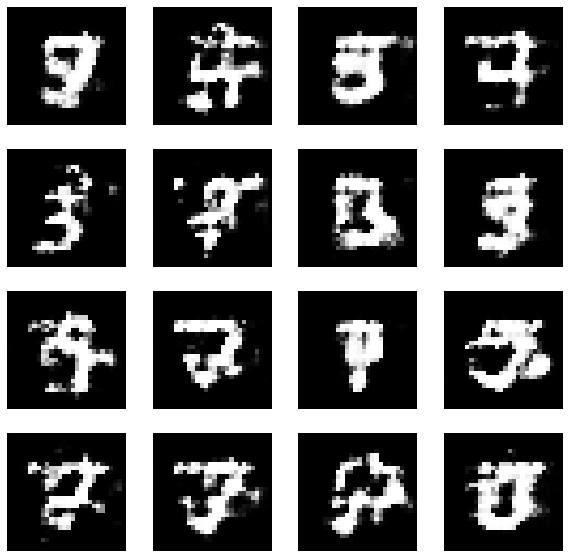

Epoch:  24


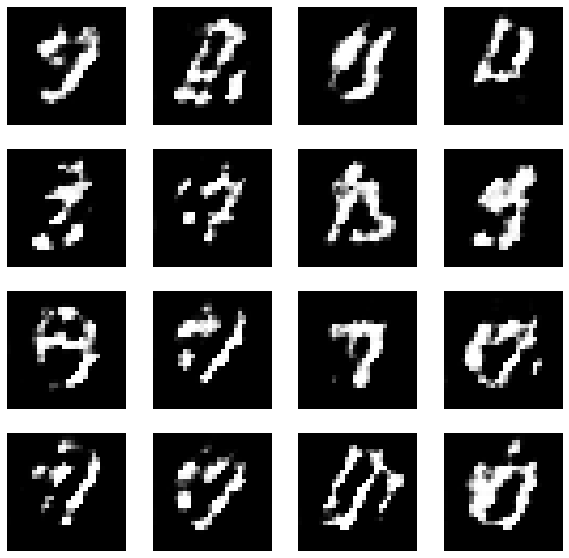

Epoch:  25


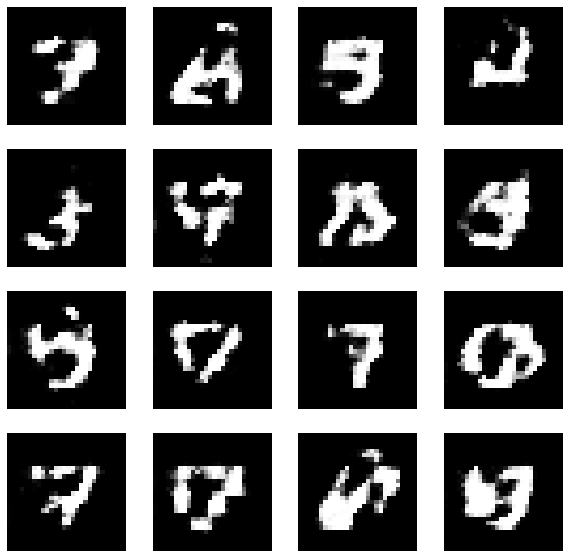

Epoch:  26


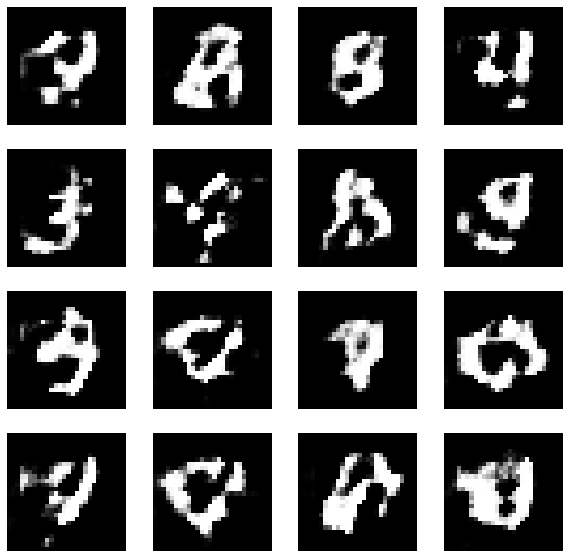

Epoch:  27


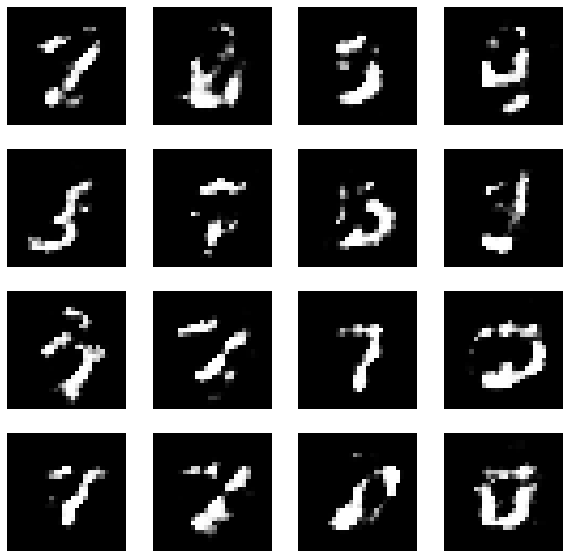

Epoch:  28


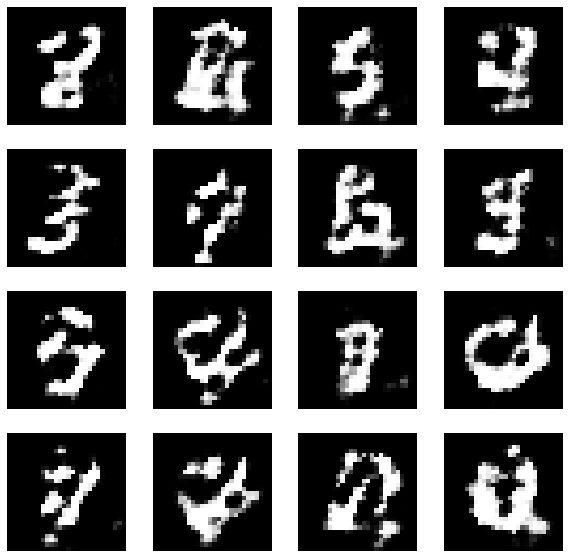

Epoch:  29


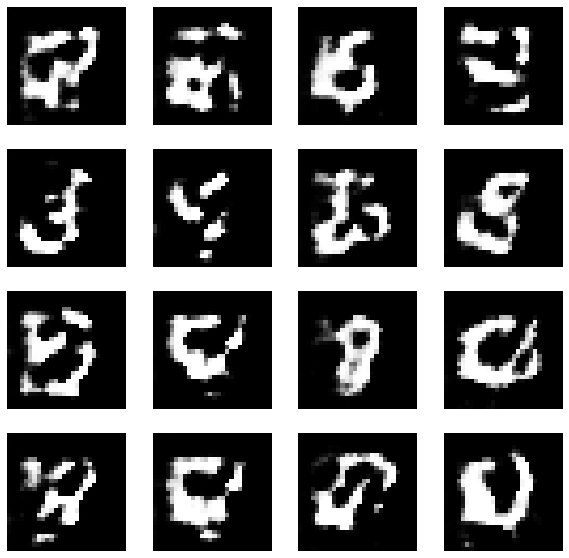

Epoch:  30


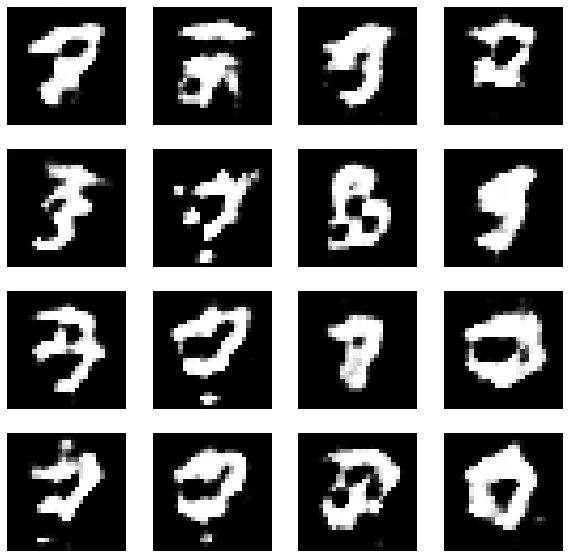

Epoch:  31


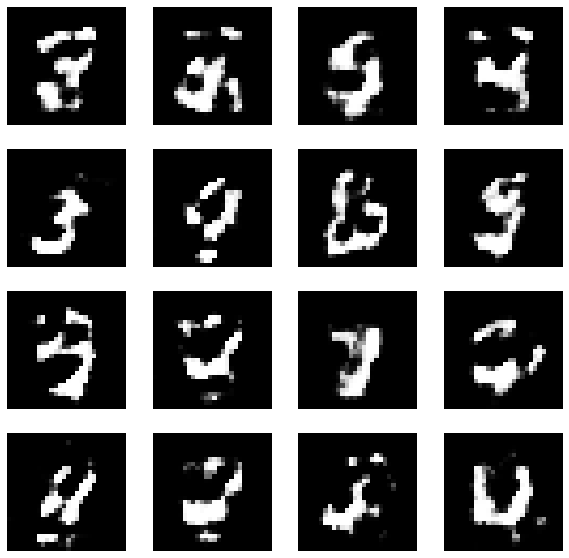

Epoch:  32


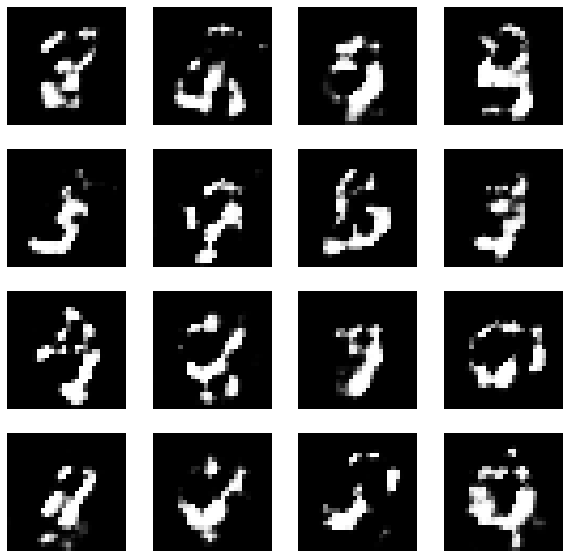

Epoch:  33


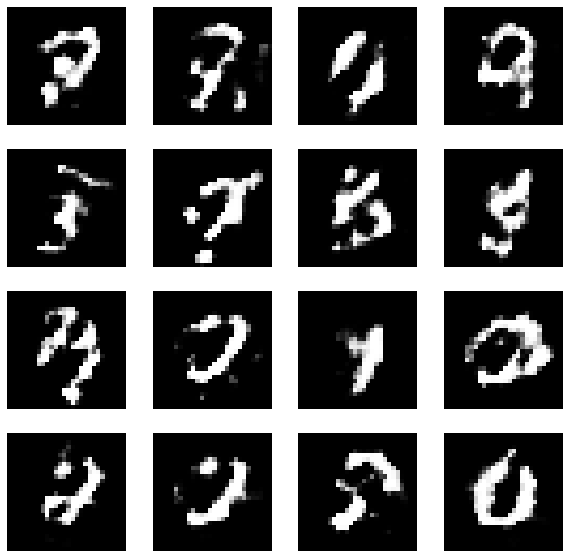

Epoch:  34


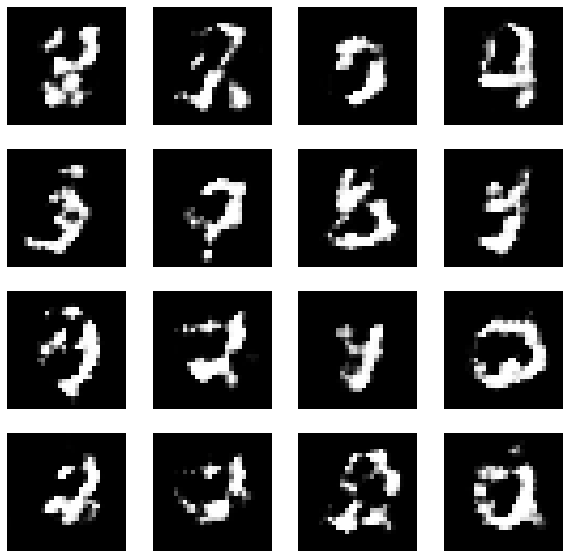

Epoch:  35


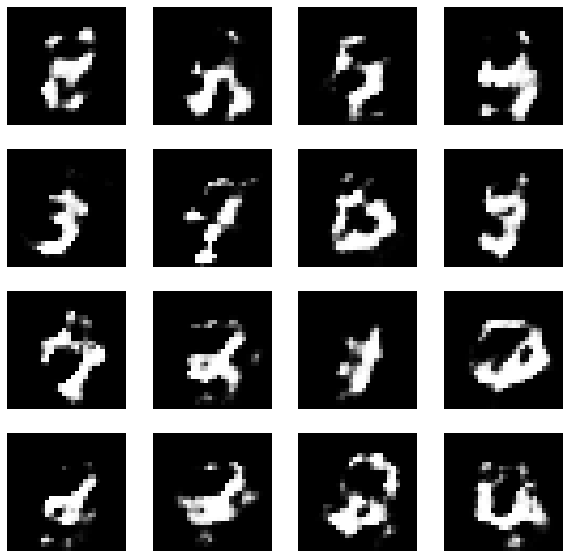

Epoch:  36


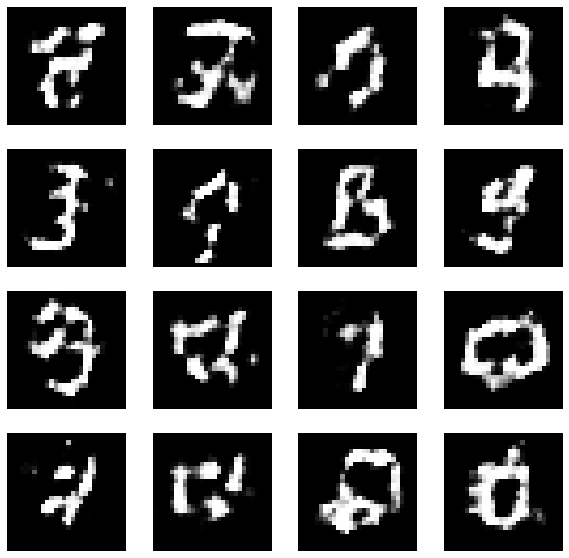

Epoch:  37


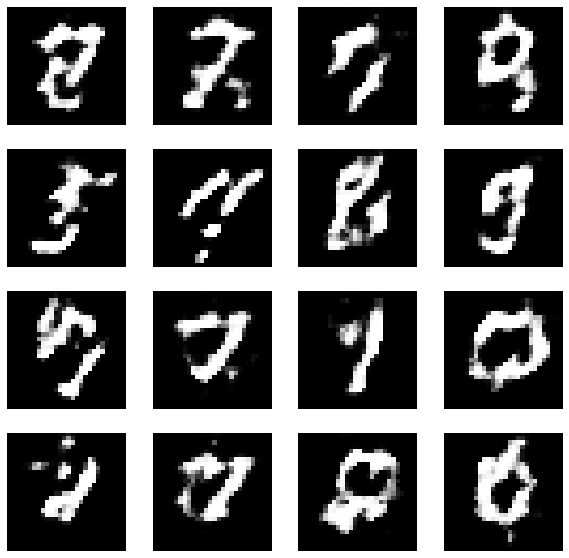

Epoch:  38


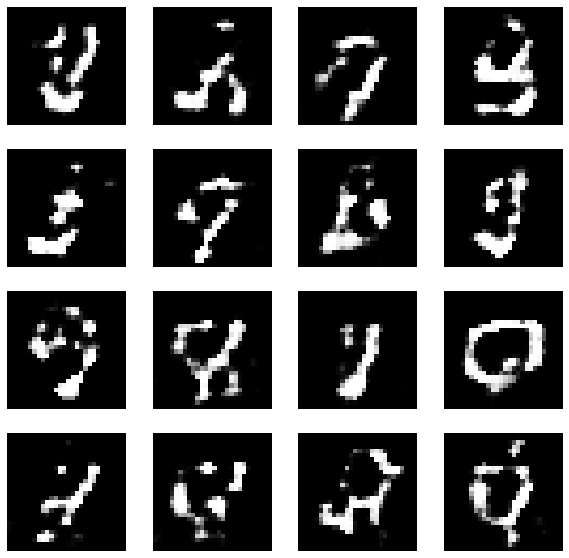

Epoch:  39


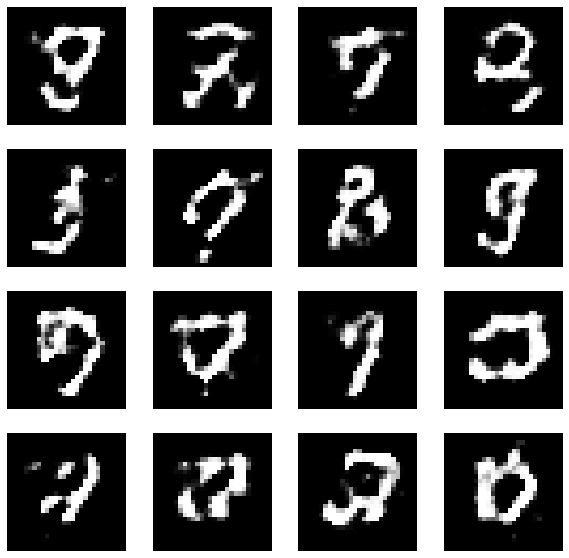

Epoch:  40


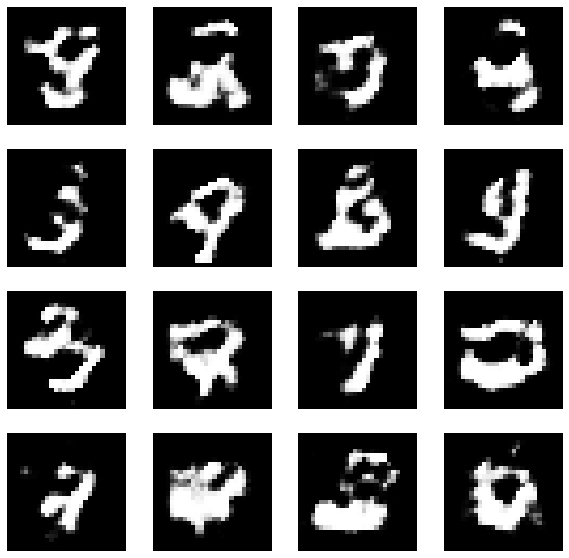

Epoch:  41


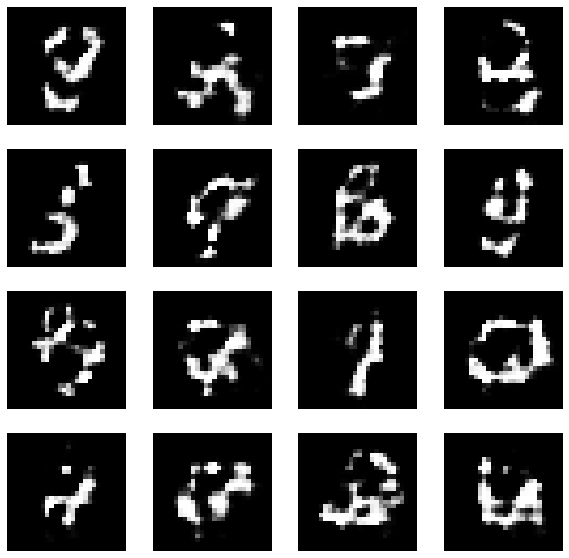

Epoch:  42


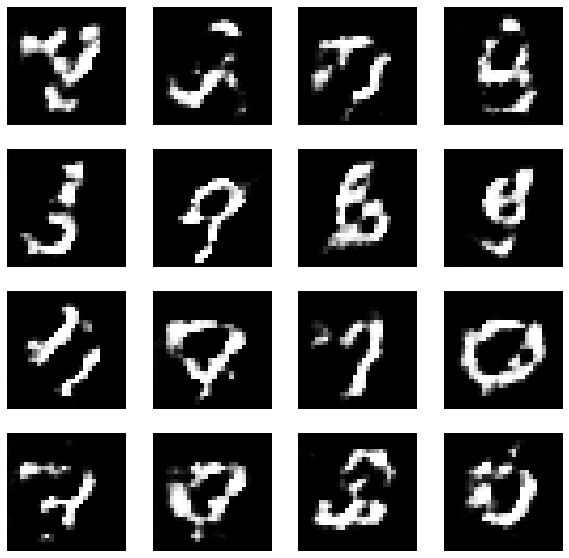

Epoch:  43


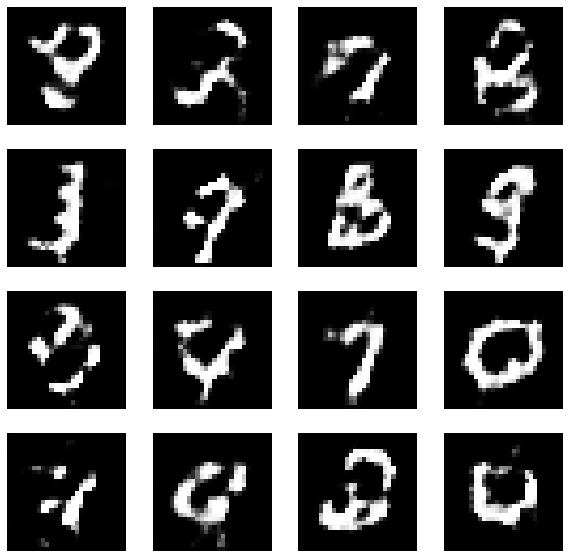

Epoch:  44


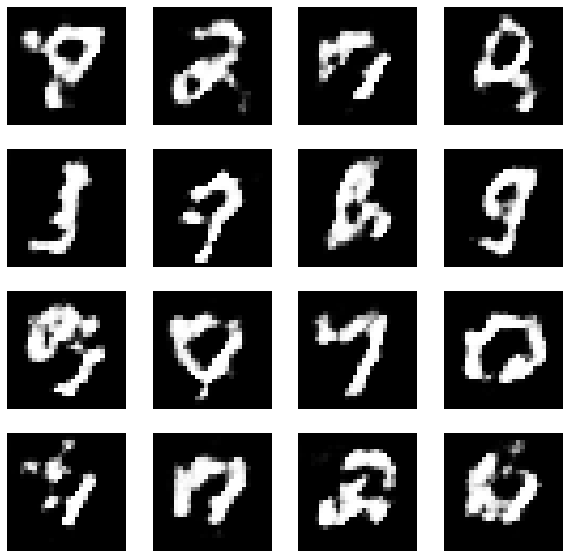

Epoch:  45


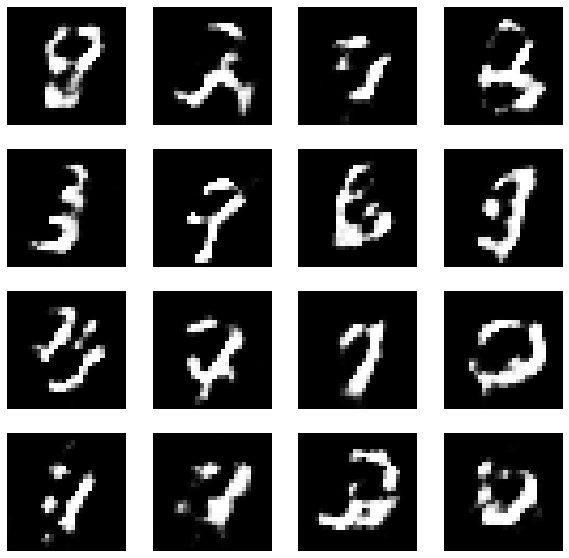

Epoch:  46


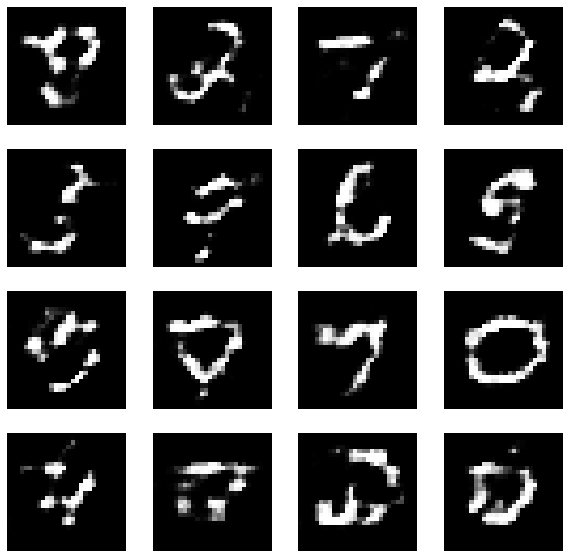

Epoch:  47


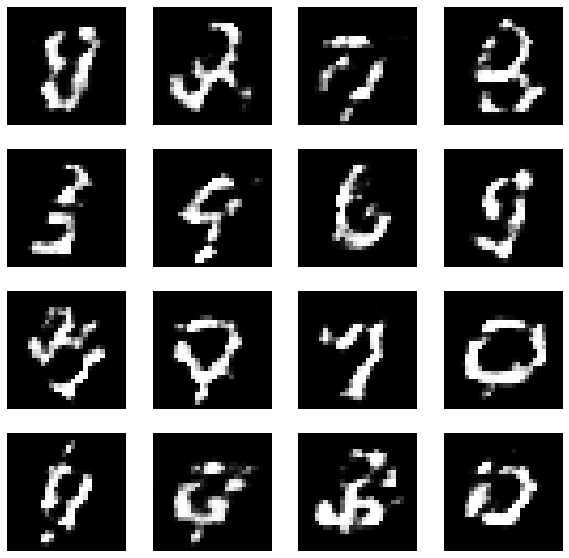

Epoch:  48


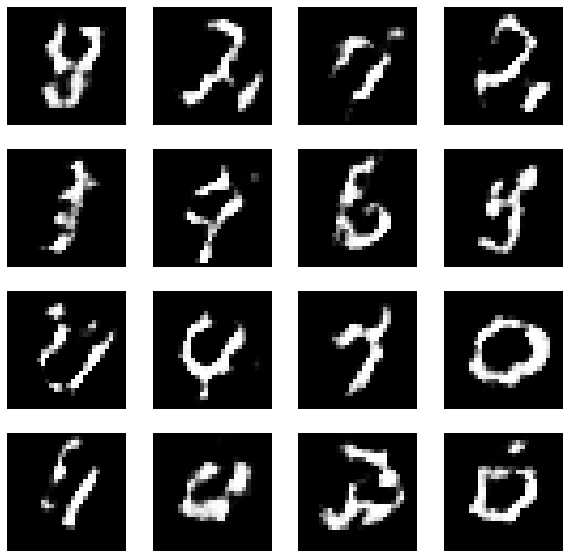

Epoch:  49


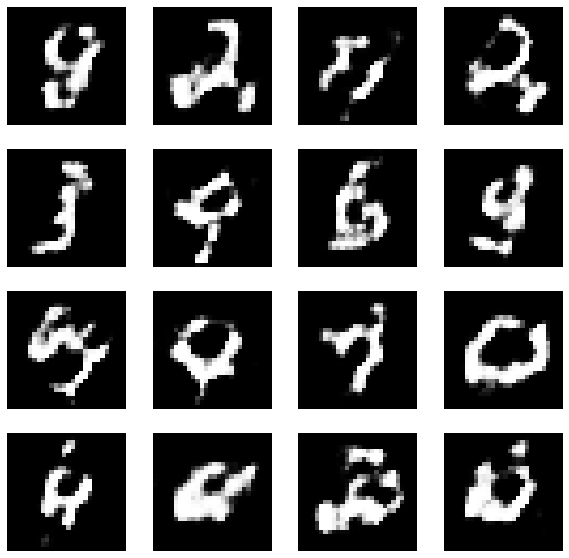

Epoch:  50


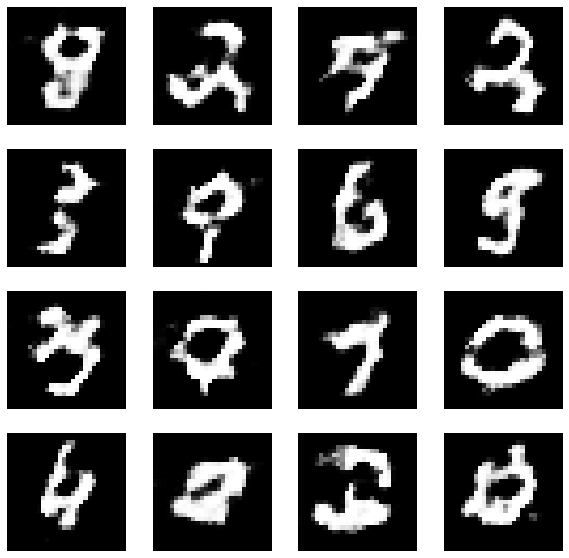

Epoch:  51


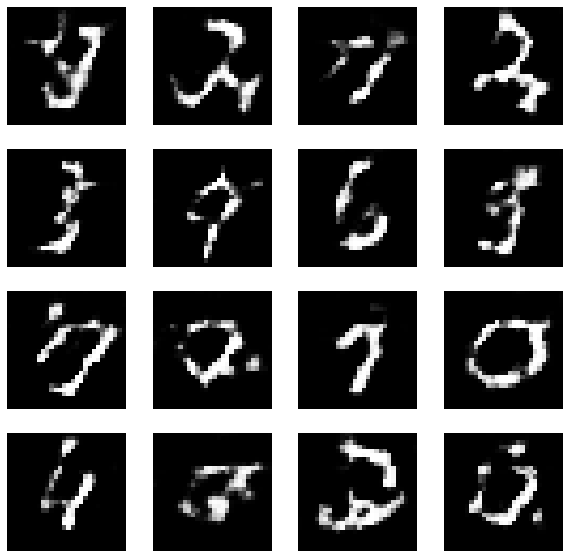

Epoch:  52


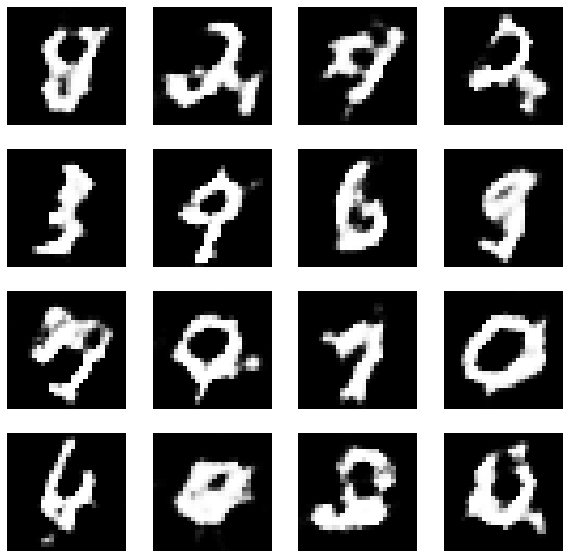

Epoch:  53


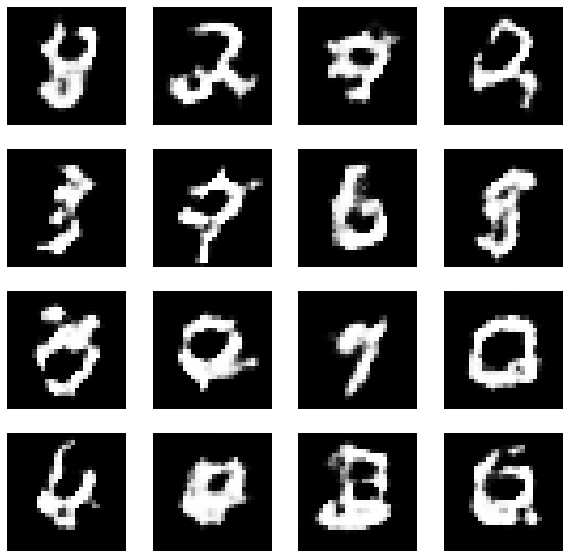

Epoch:  54


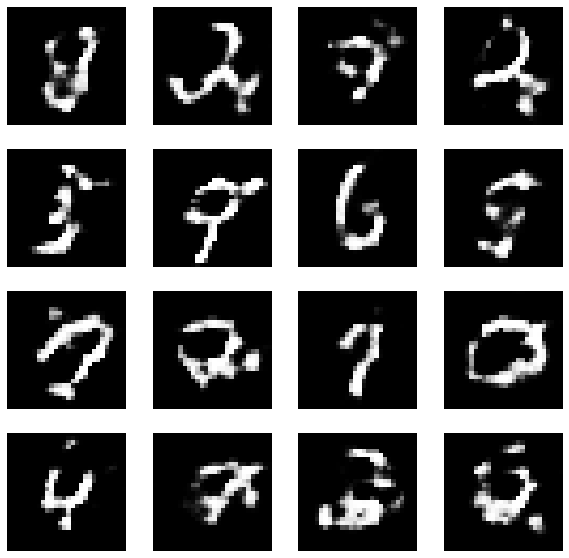

Epoch:  55


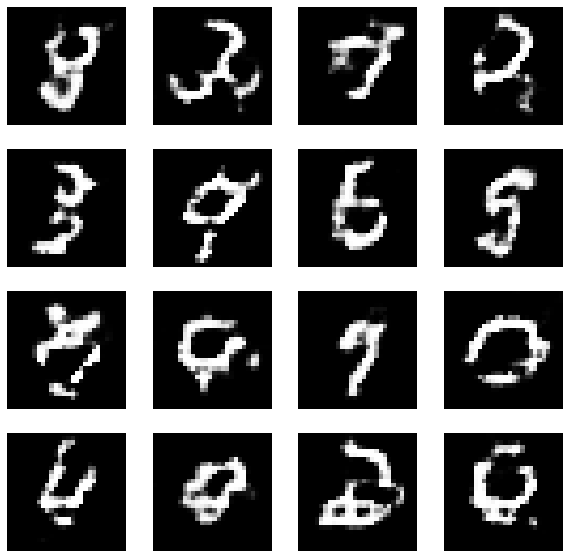

Epoch:  56


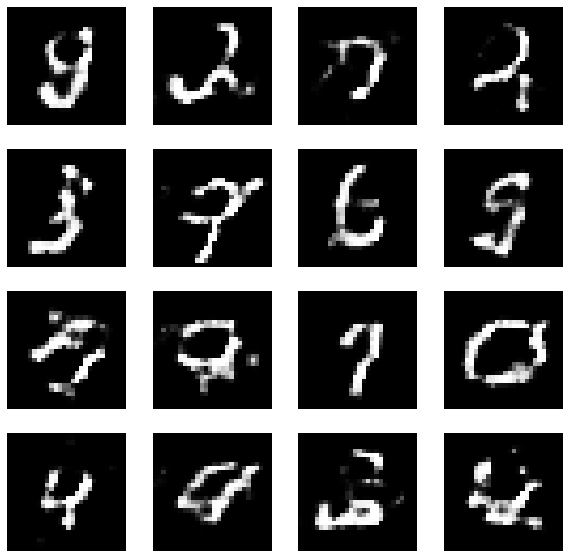

Epoch:  57


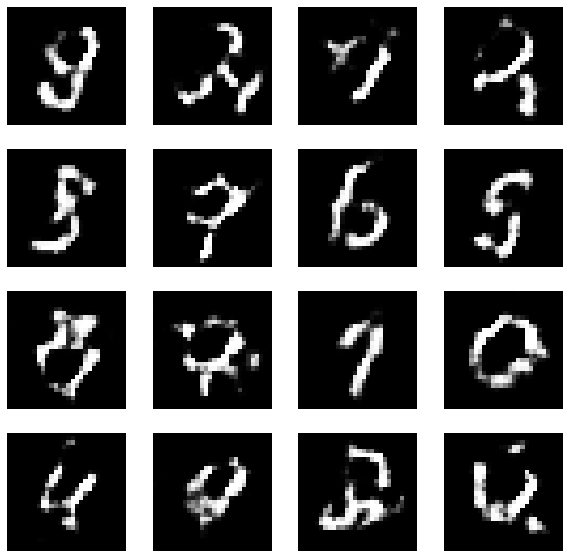

Epoch:  58


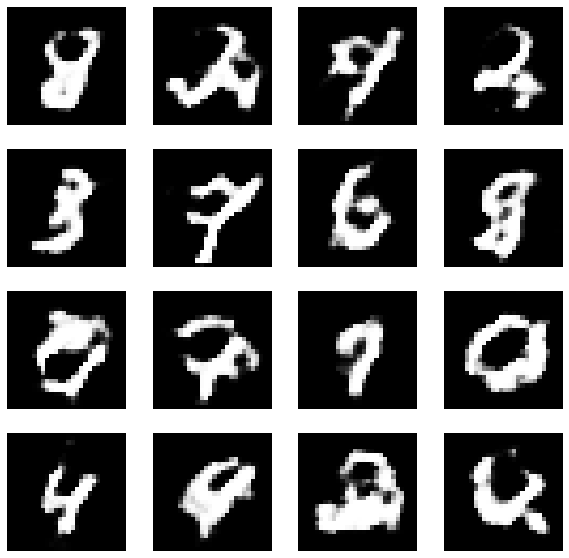

Epoch:  59


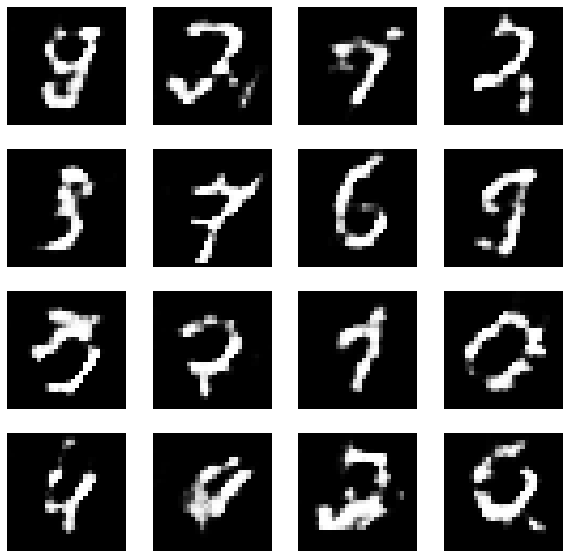

Epoch:  60


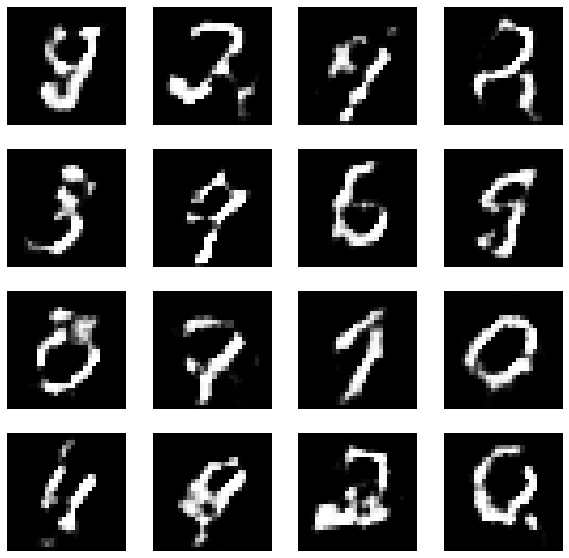

Epoch:  61


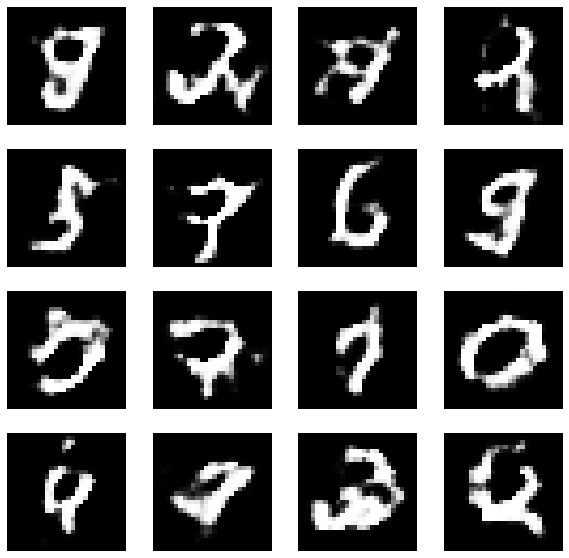

Epoch:  62


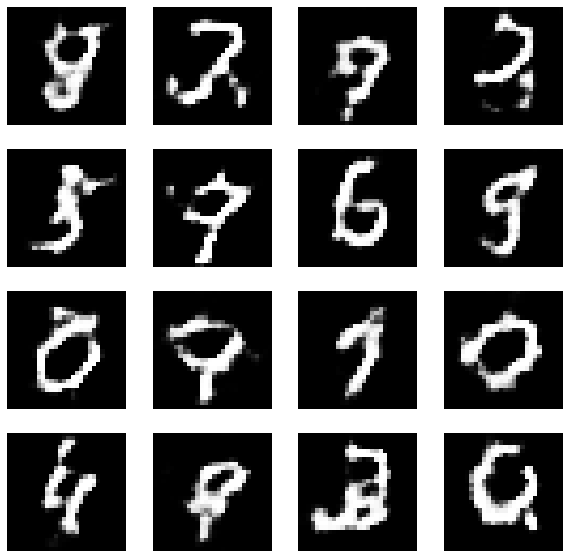

Epoch:  63


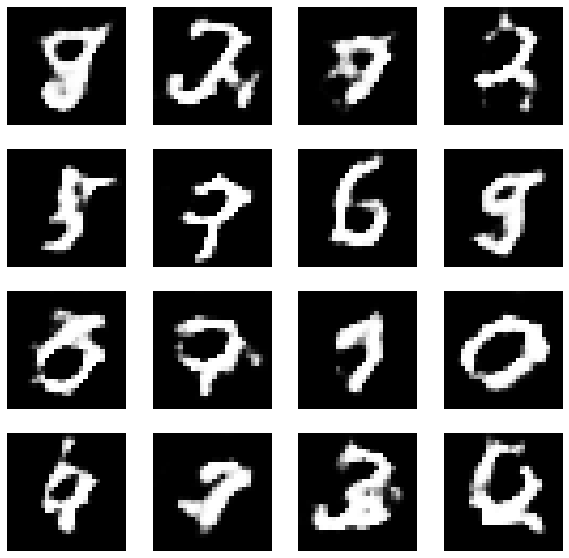

Epoch:  64


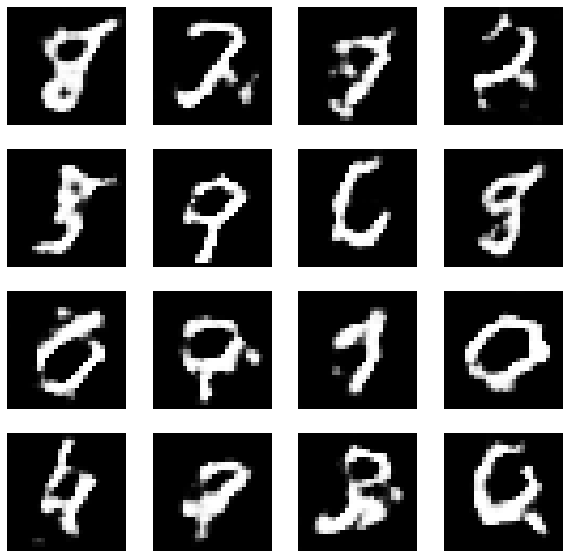

Epoch:  65


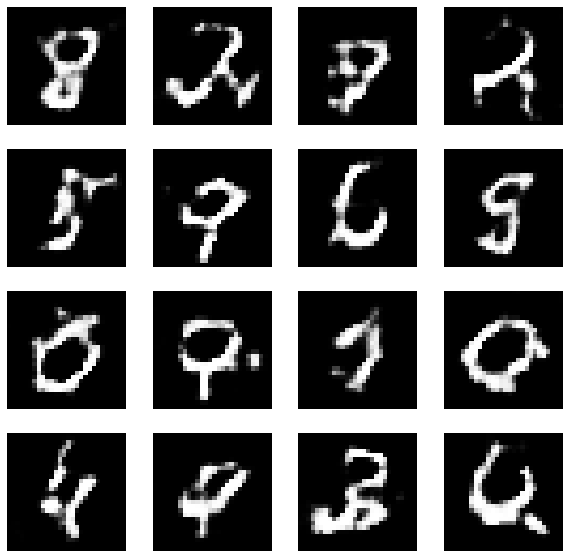

Epoch:  66


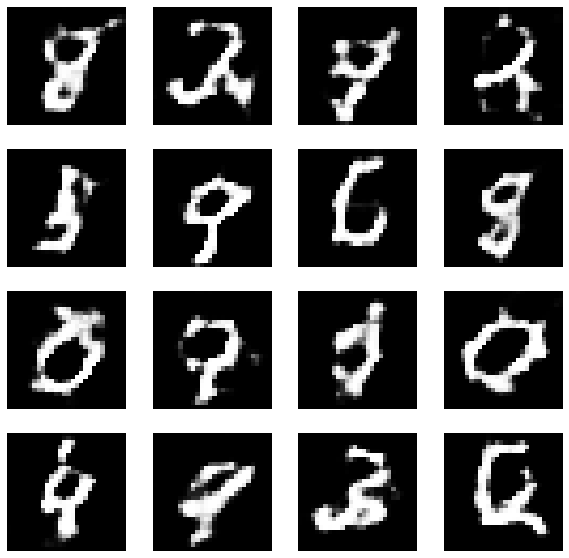

Epoch:  67


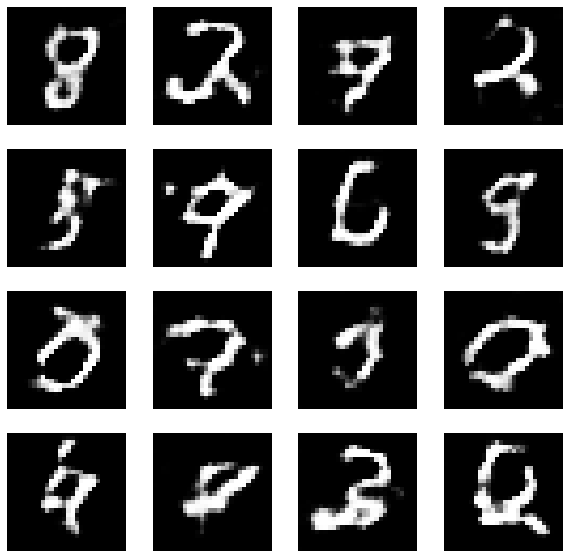

Epoch:  68


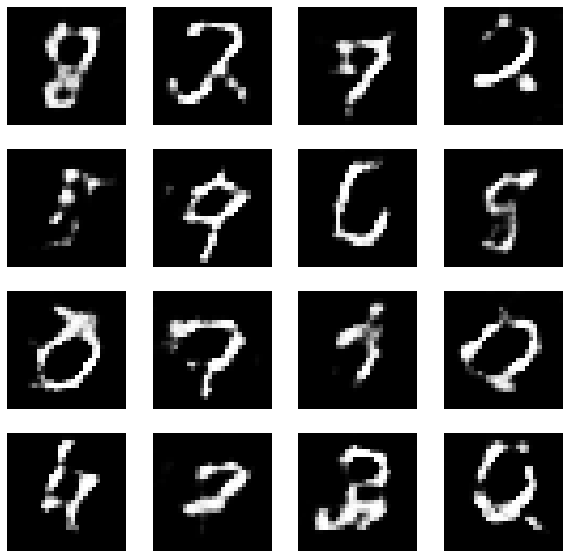

Epoch:  69


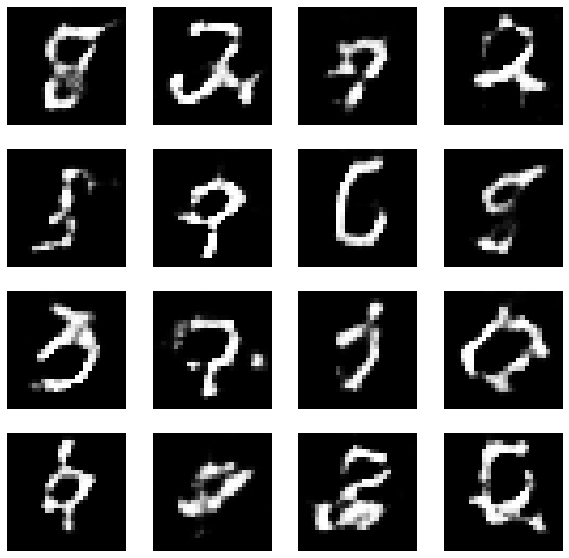

Epoch:  70


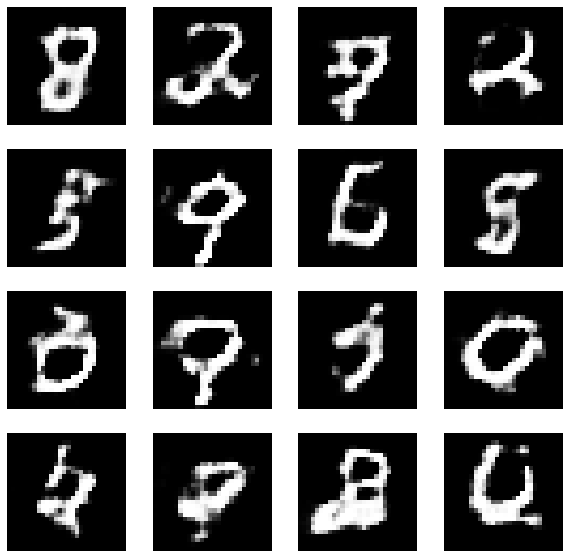

Epoch:  71


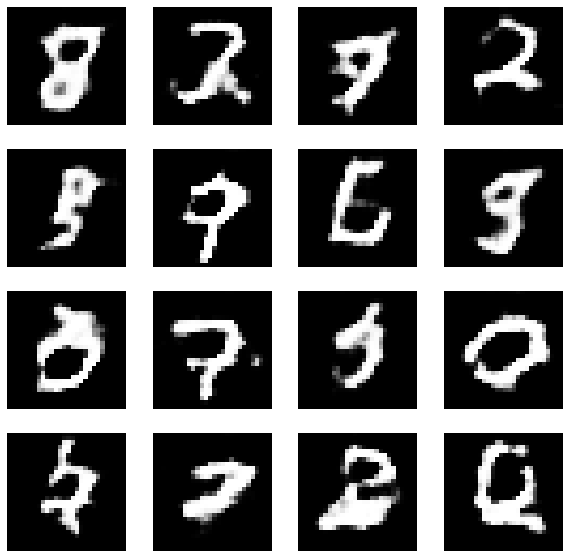

Epoch:  72


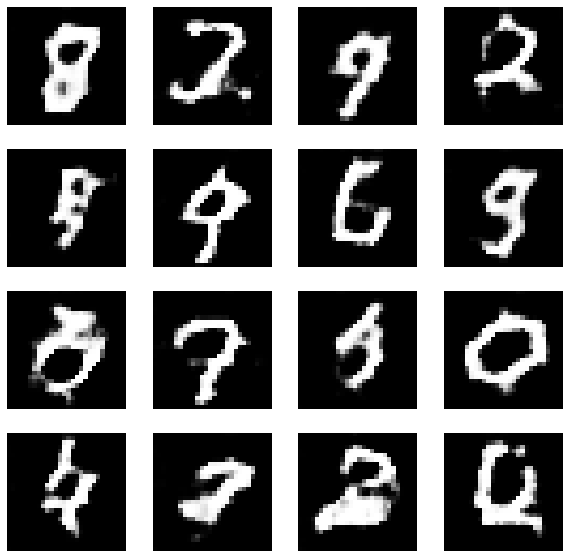

Epoch:  73


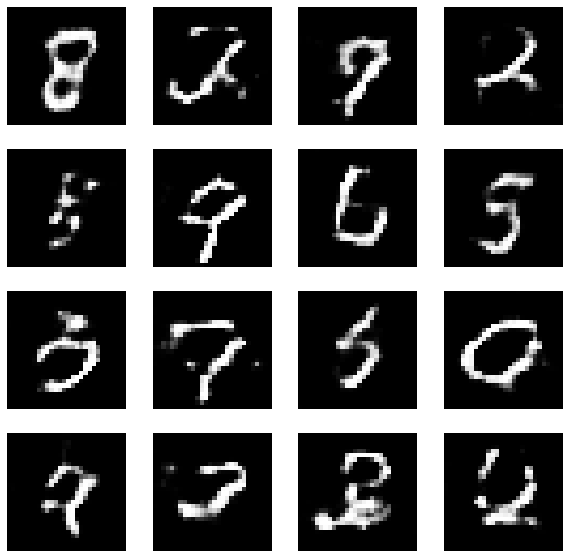

Epoch:  74


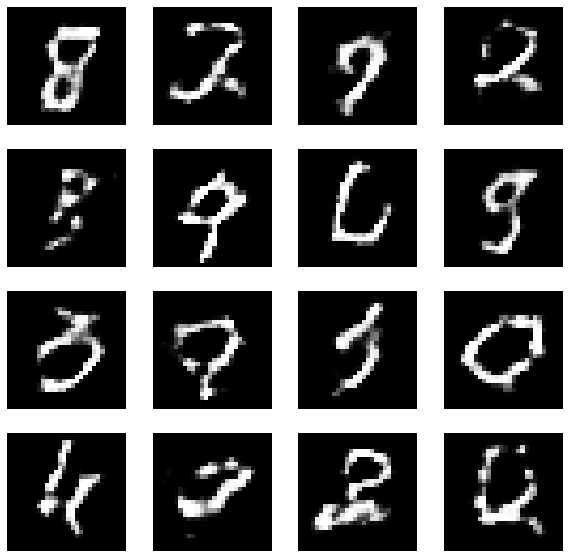

Epoch:  75


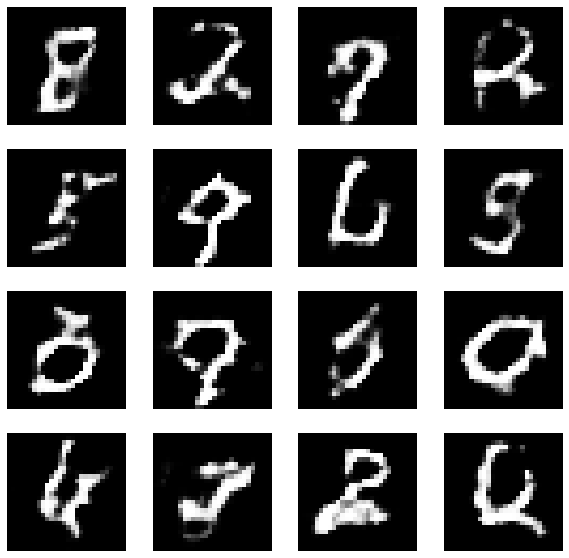

Epoch:  76


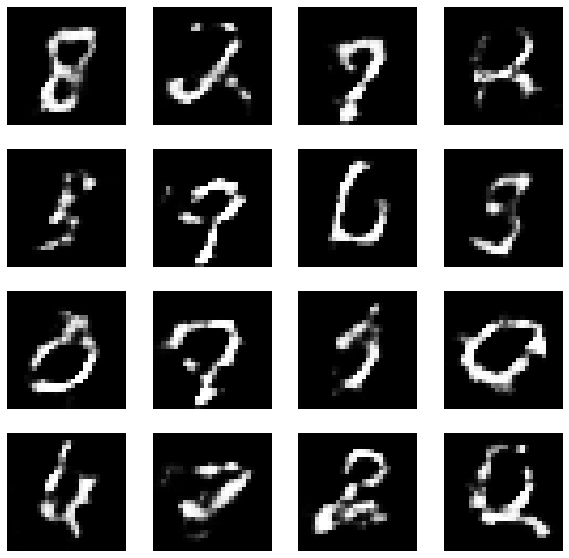

Epoch:  77


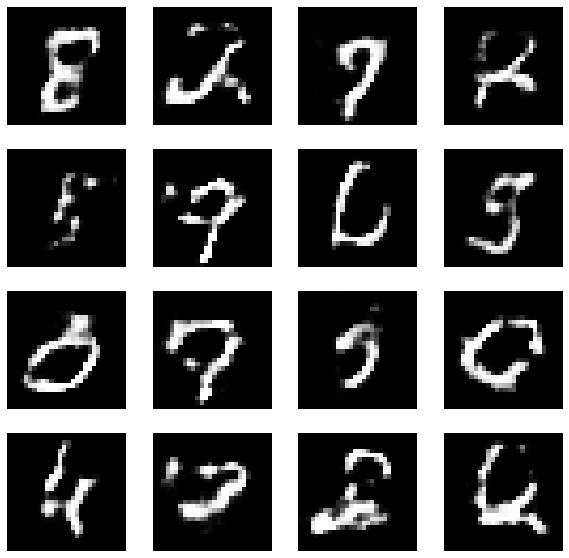

Epoch:  78


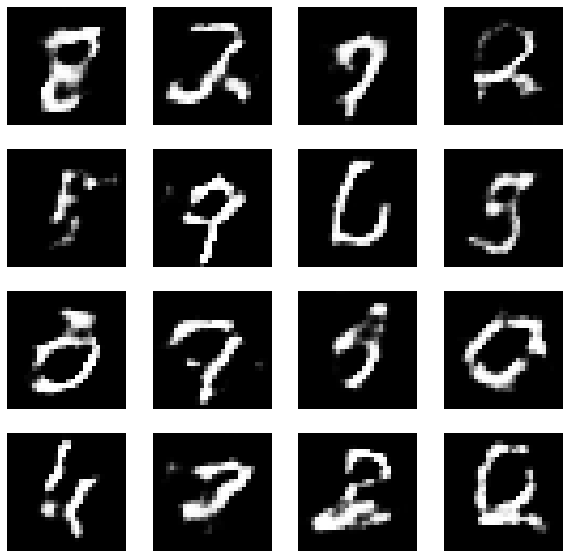

Epoch:  79


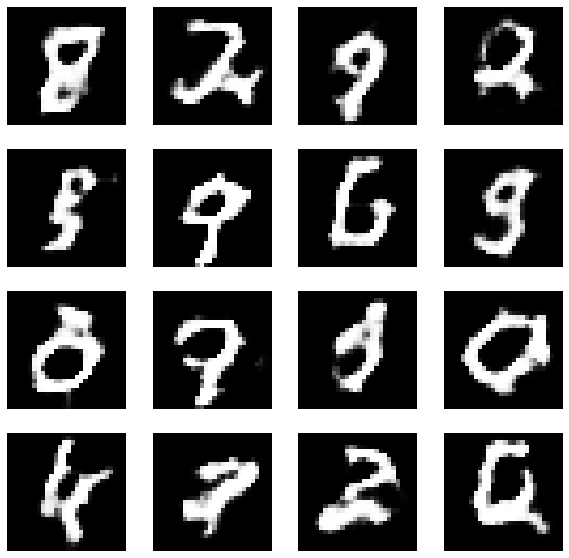

Epoch:  80


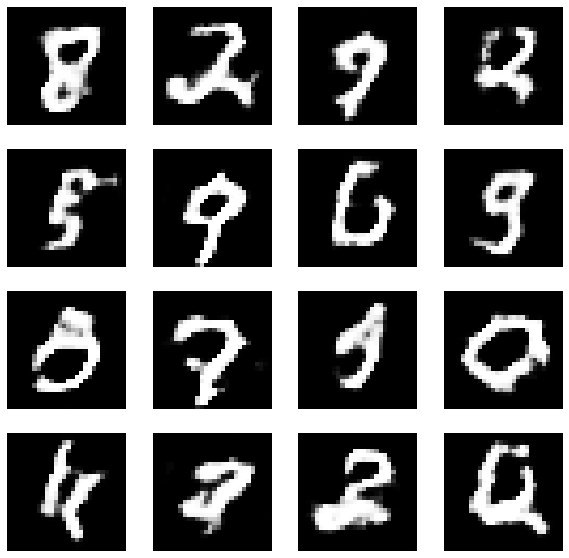

Epoch:  81


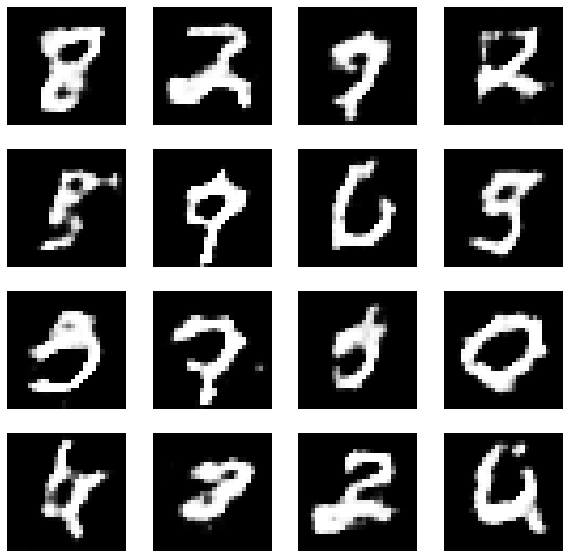

Epoch:  82


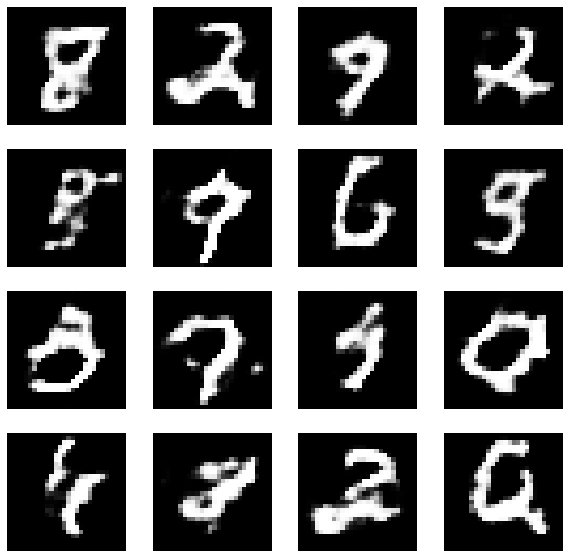

Epoch:  83


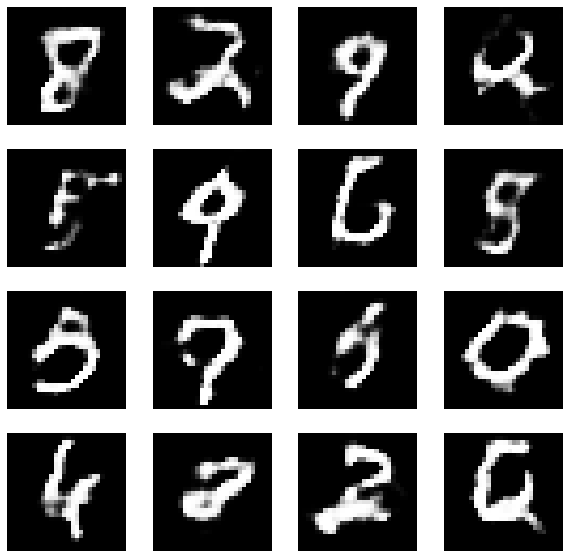

Epoch:  84


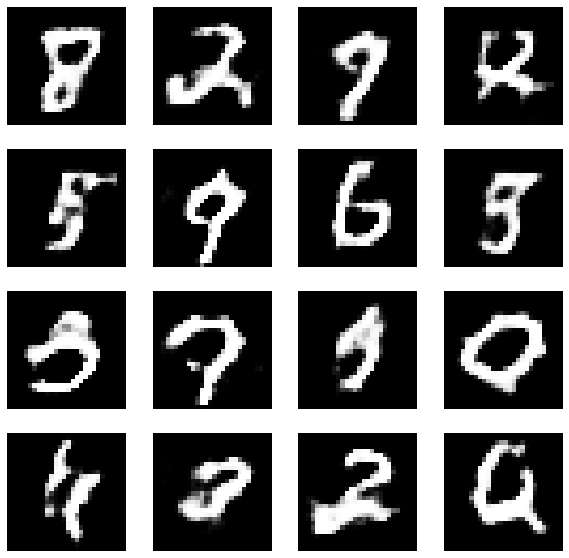

Epoch:  85


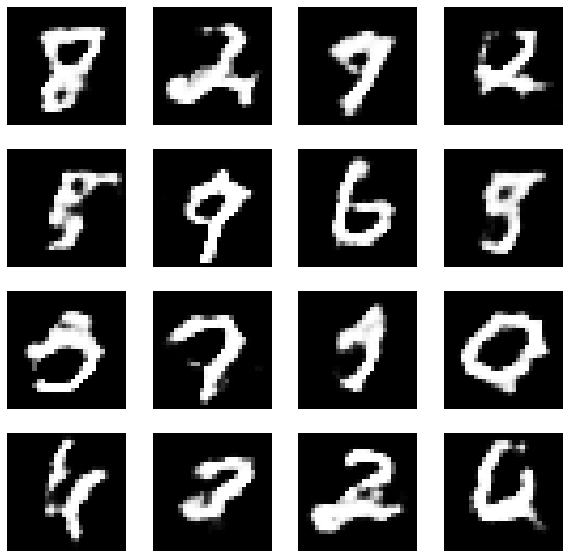

Epoch:  86


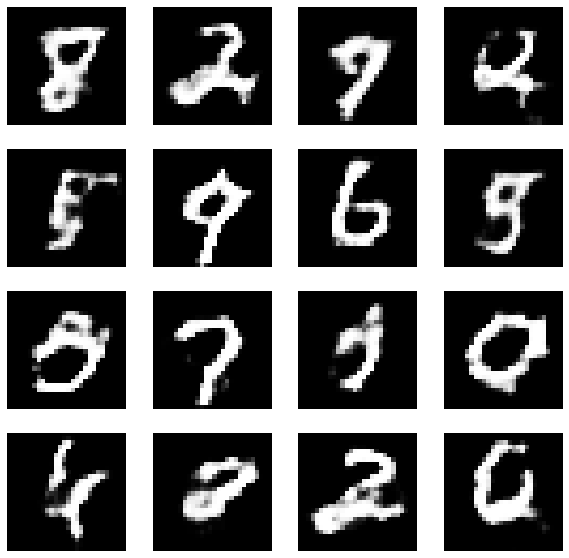

Epoch:  87


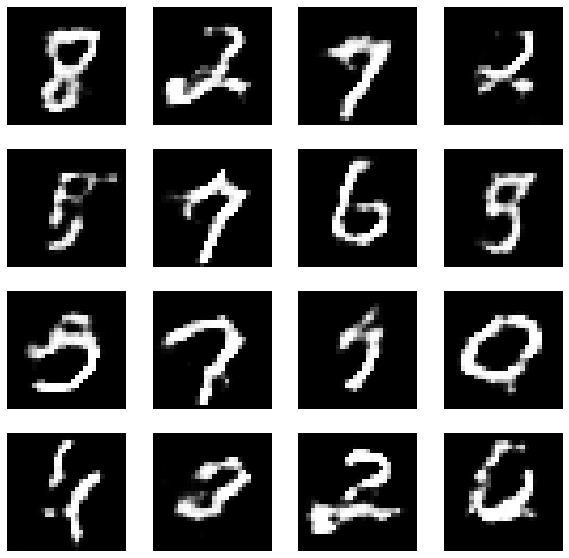

Epoch:  88


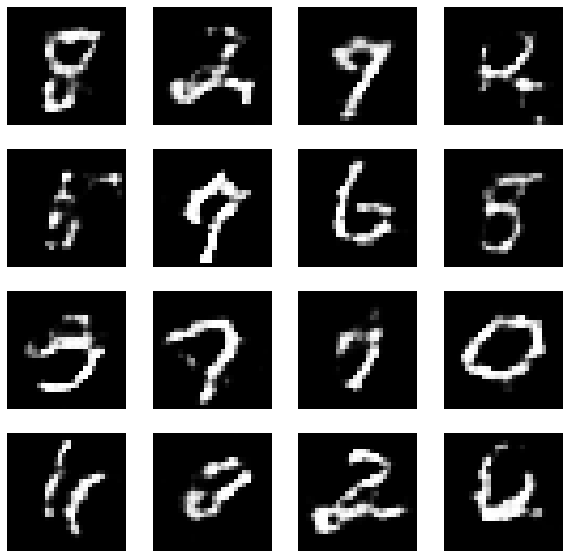

Epoch:  89


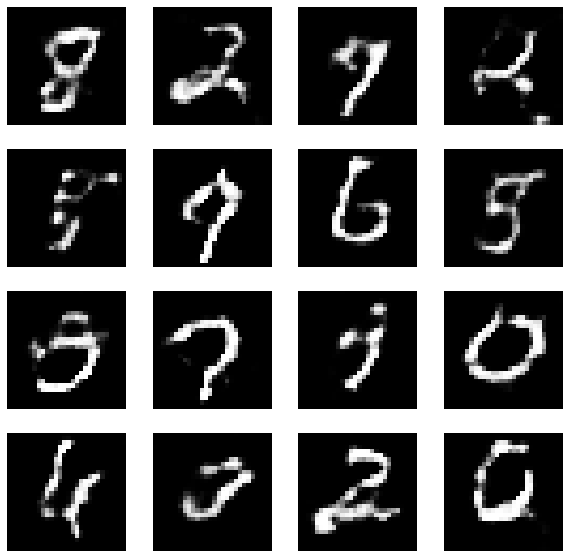

Epoch:  90


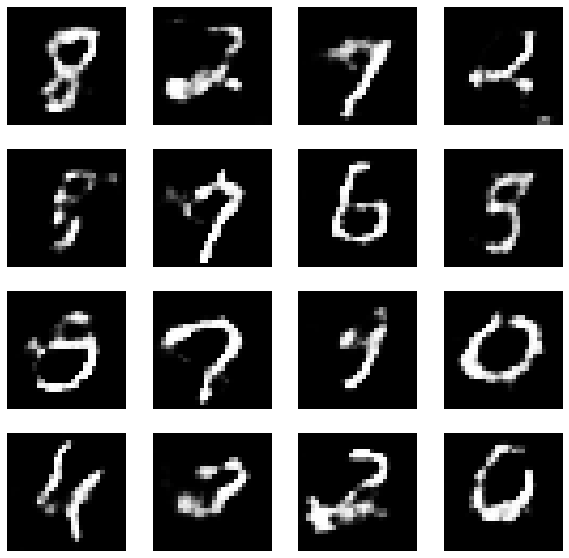

Epoch:  91


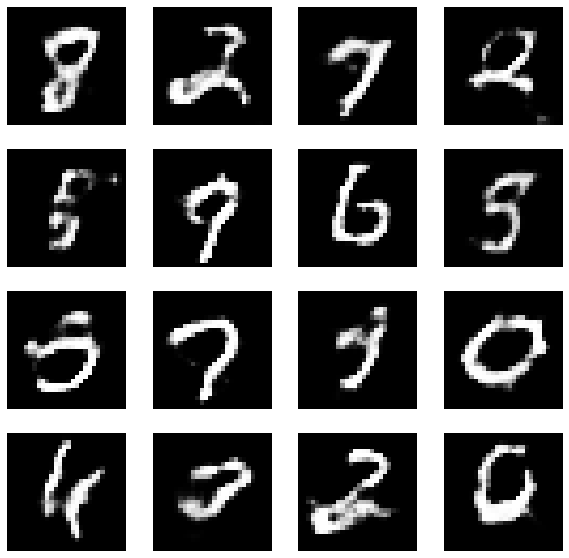

Epoch:  92


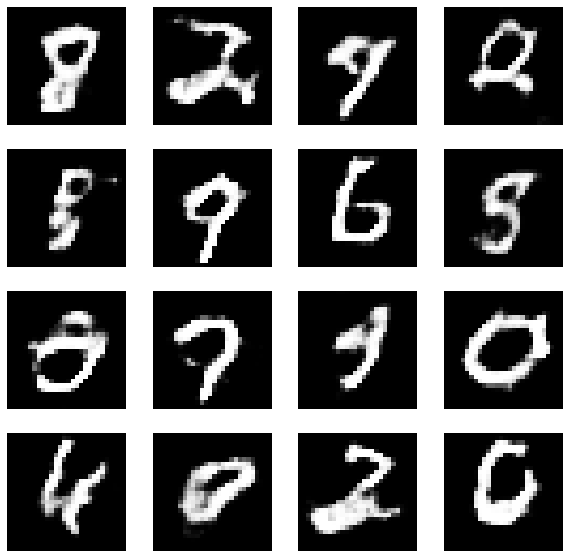

Epoch:  93


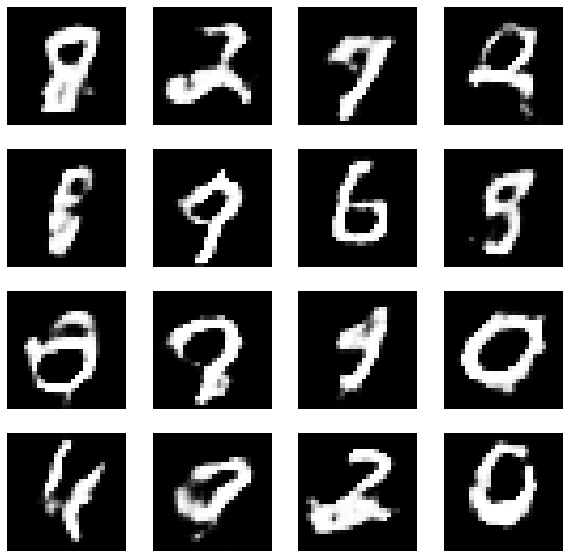

Epoch:  94


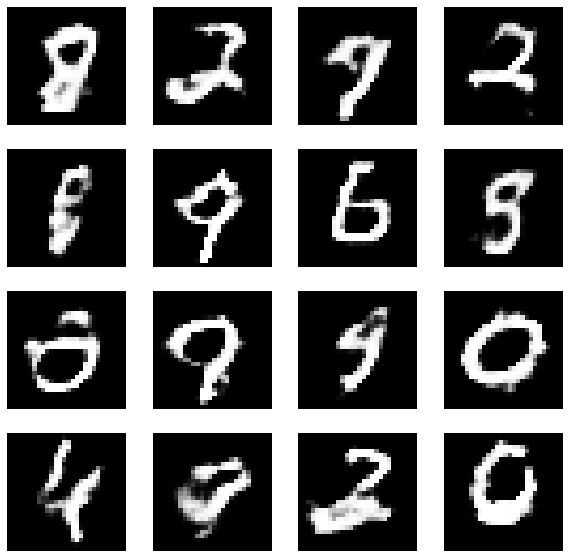

Epoch:  95


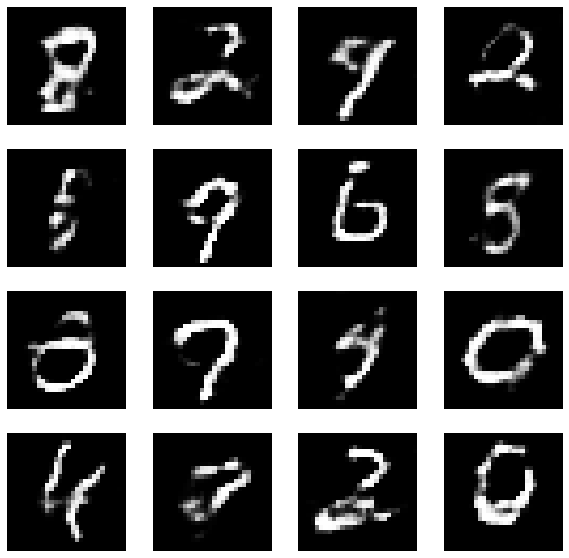

Epoch:  96


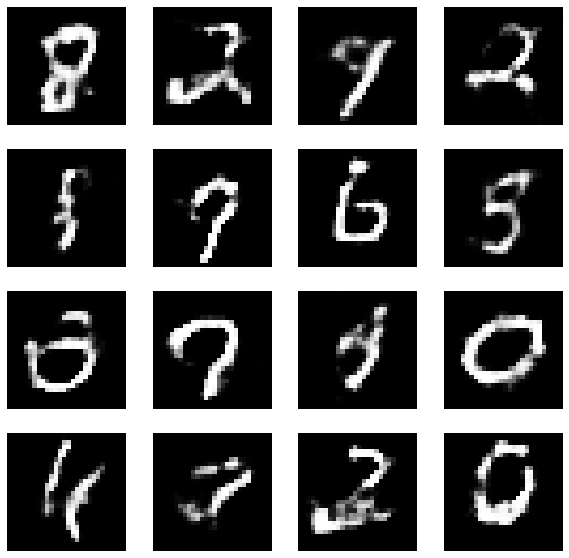

Epoch:  97


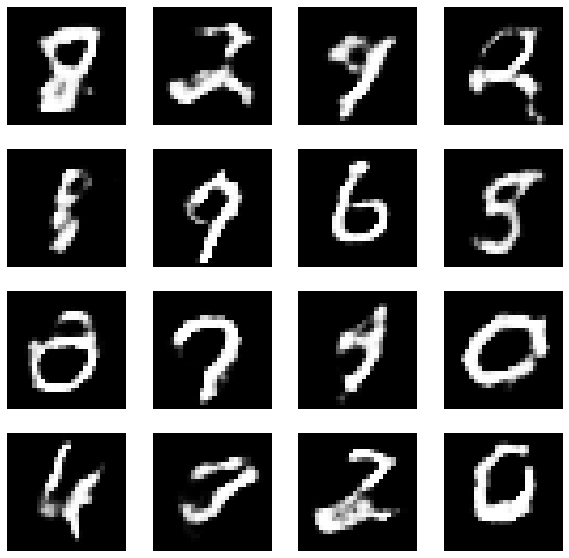

Epoch:  98


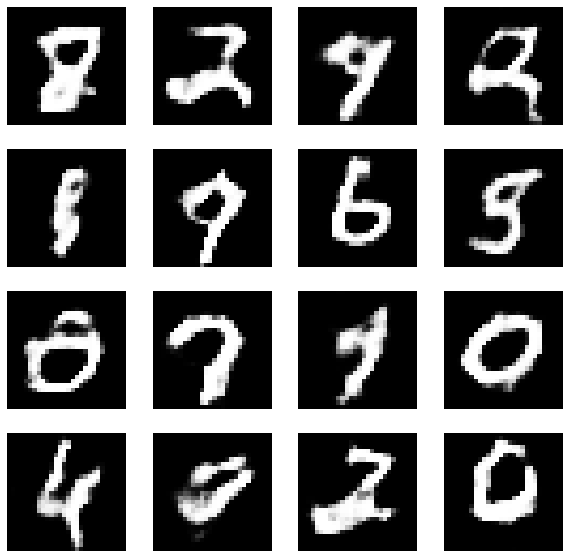

Epoch:  99


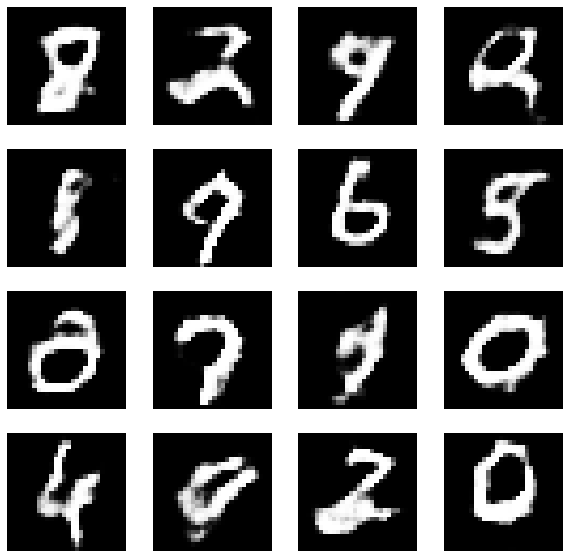

Epoch:  100


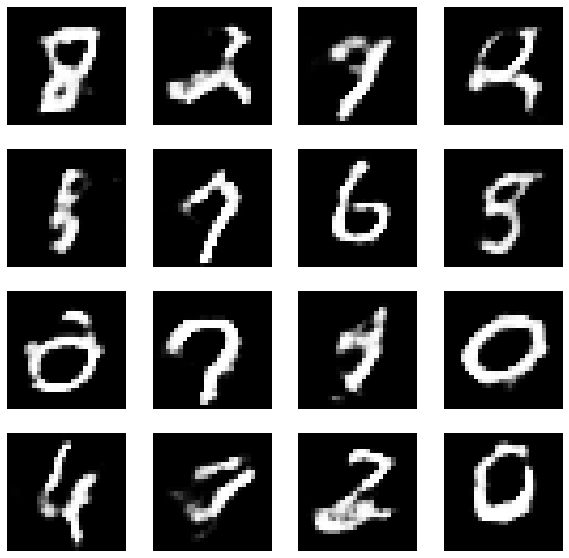

In [ ]:
train(X_train, epochs, test_images)